Clustergrößen:
Merged_Cluster
0        100
1       4800
19     11500
21       100
23       100
136      100
137      500
155      900
162     7800
168      100
240      200
242     2500
287    10100
388     6200
Name: count, dtype: int64


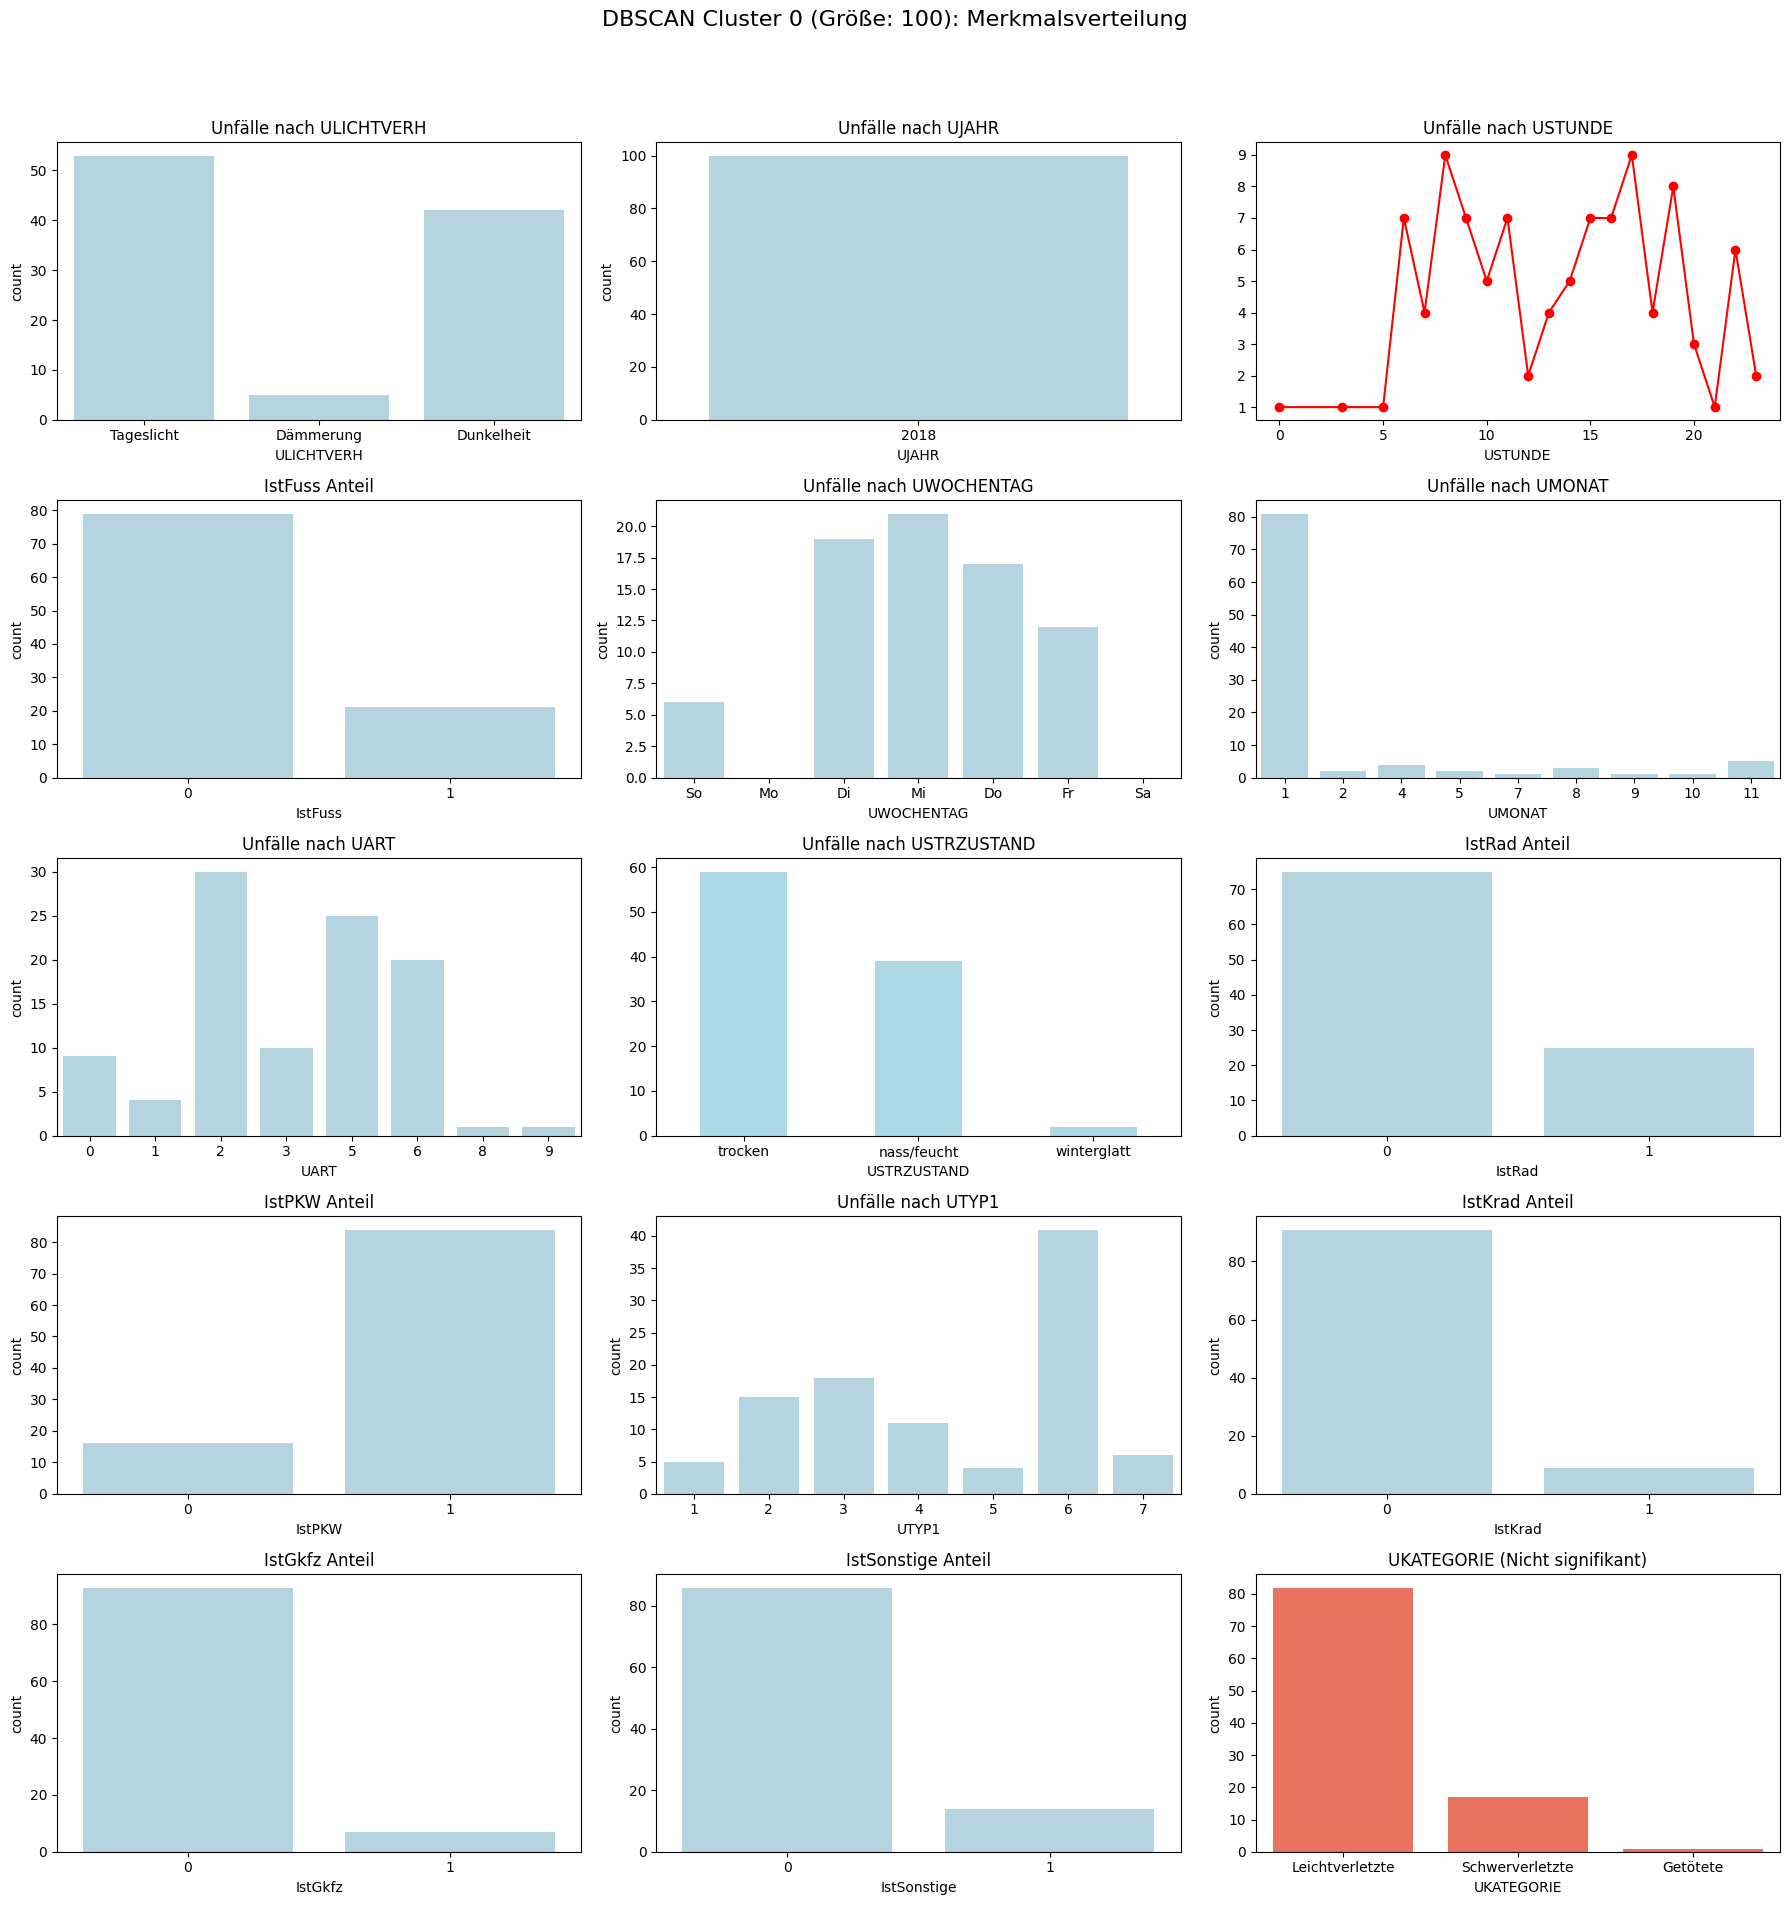

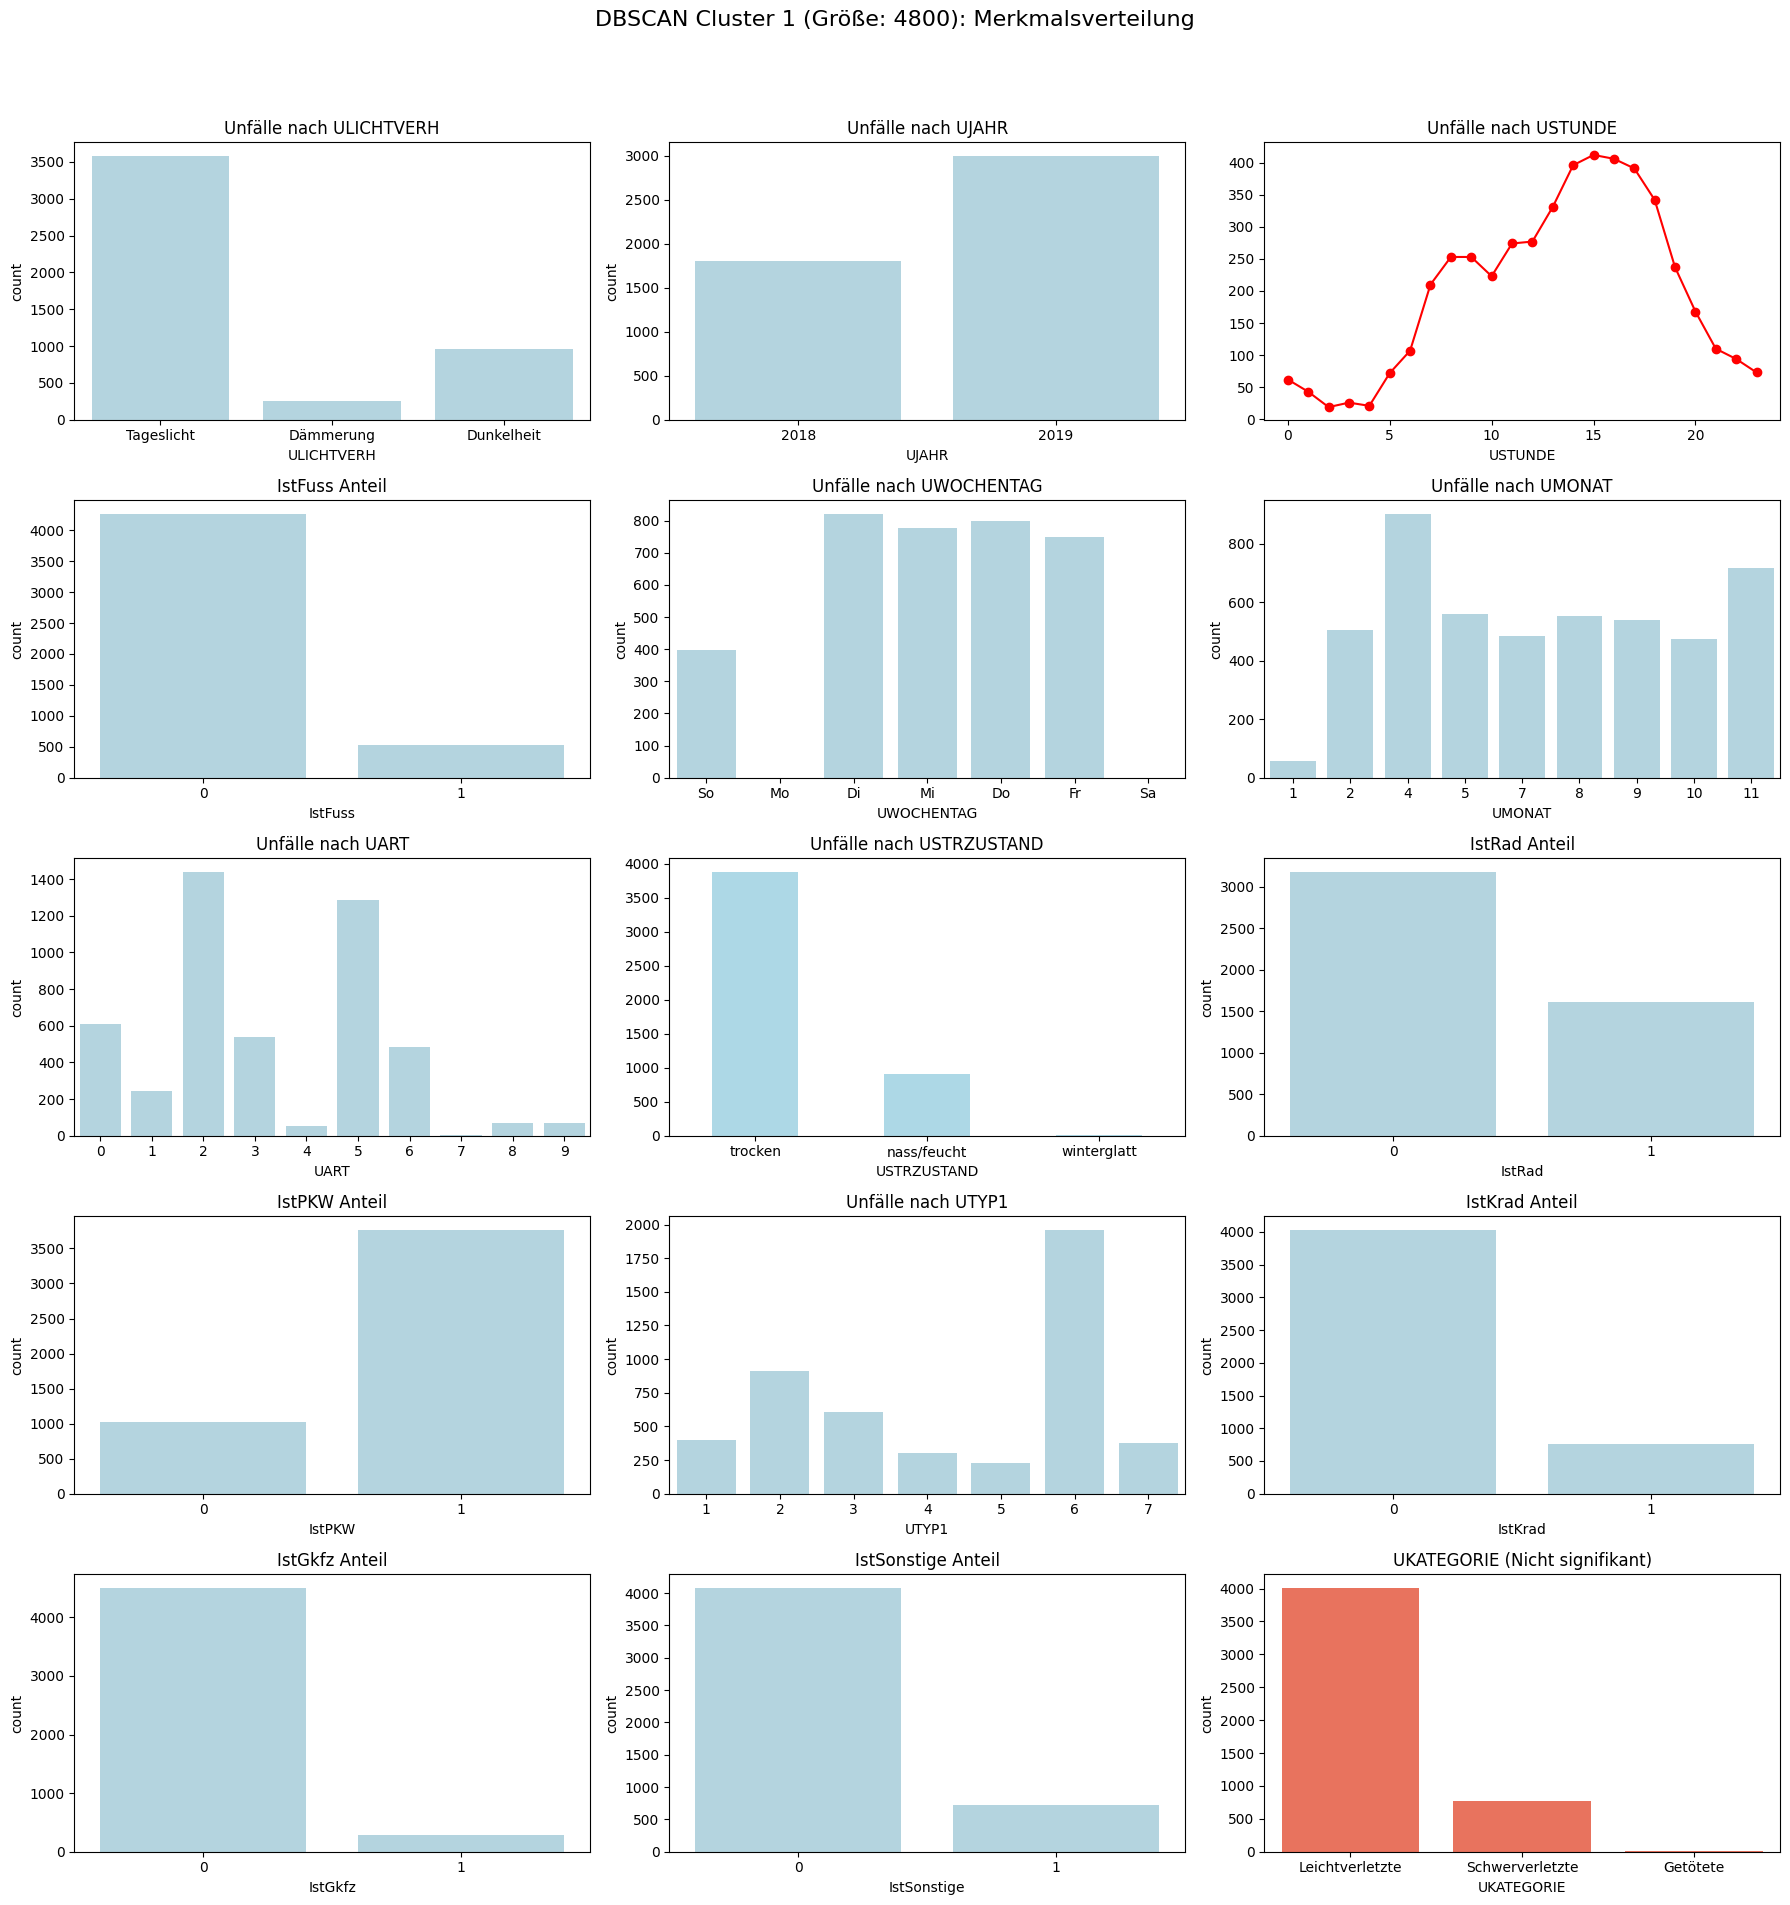

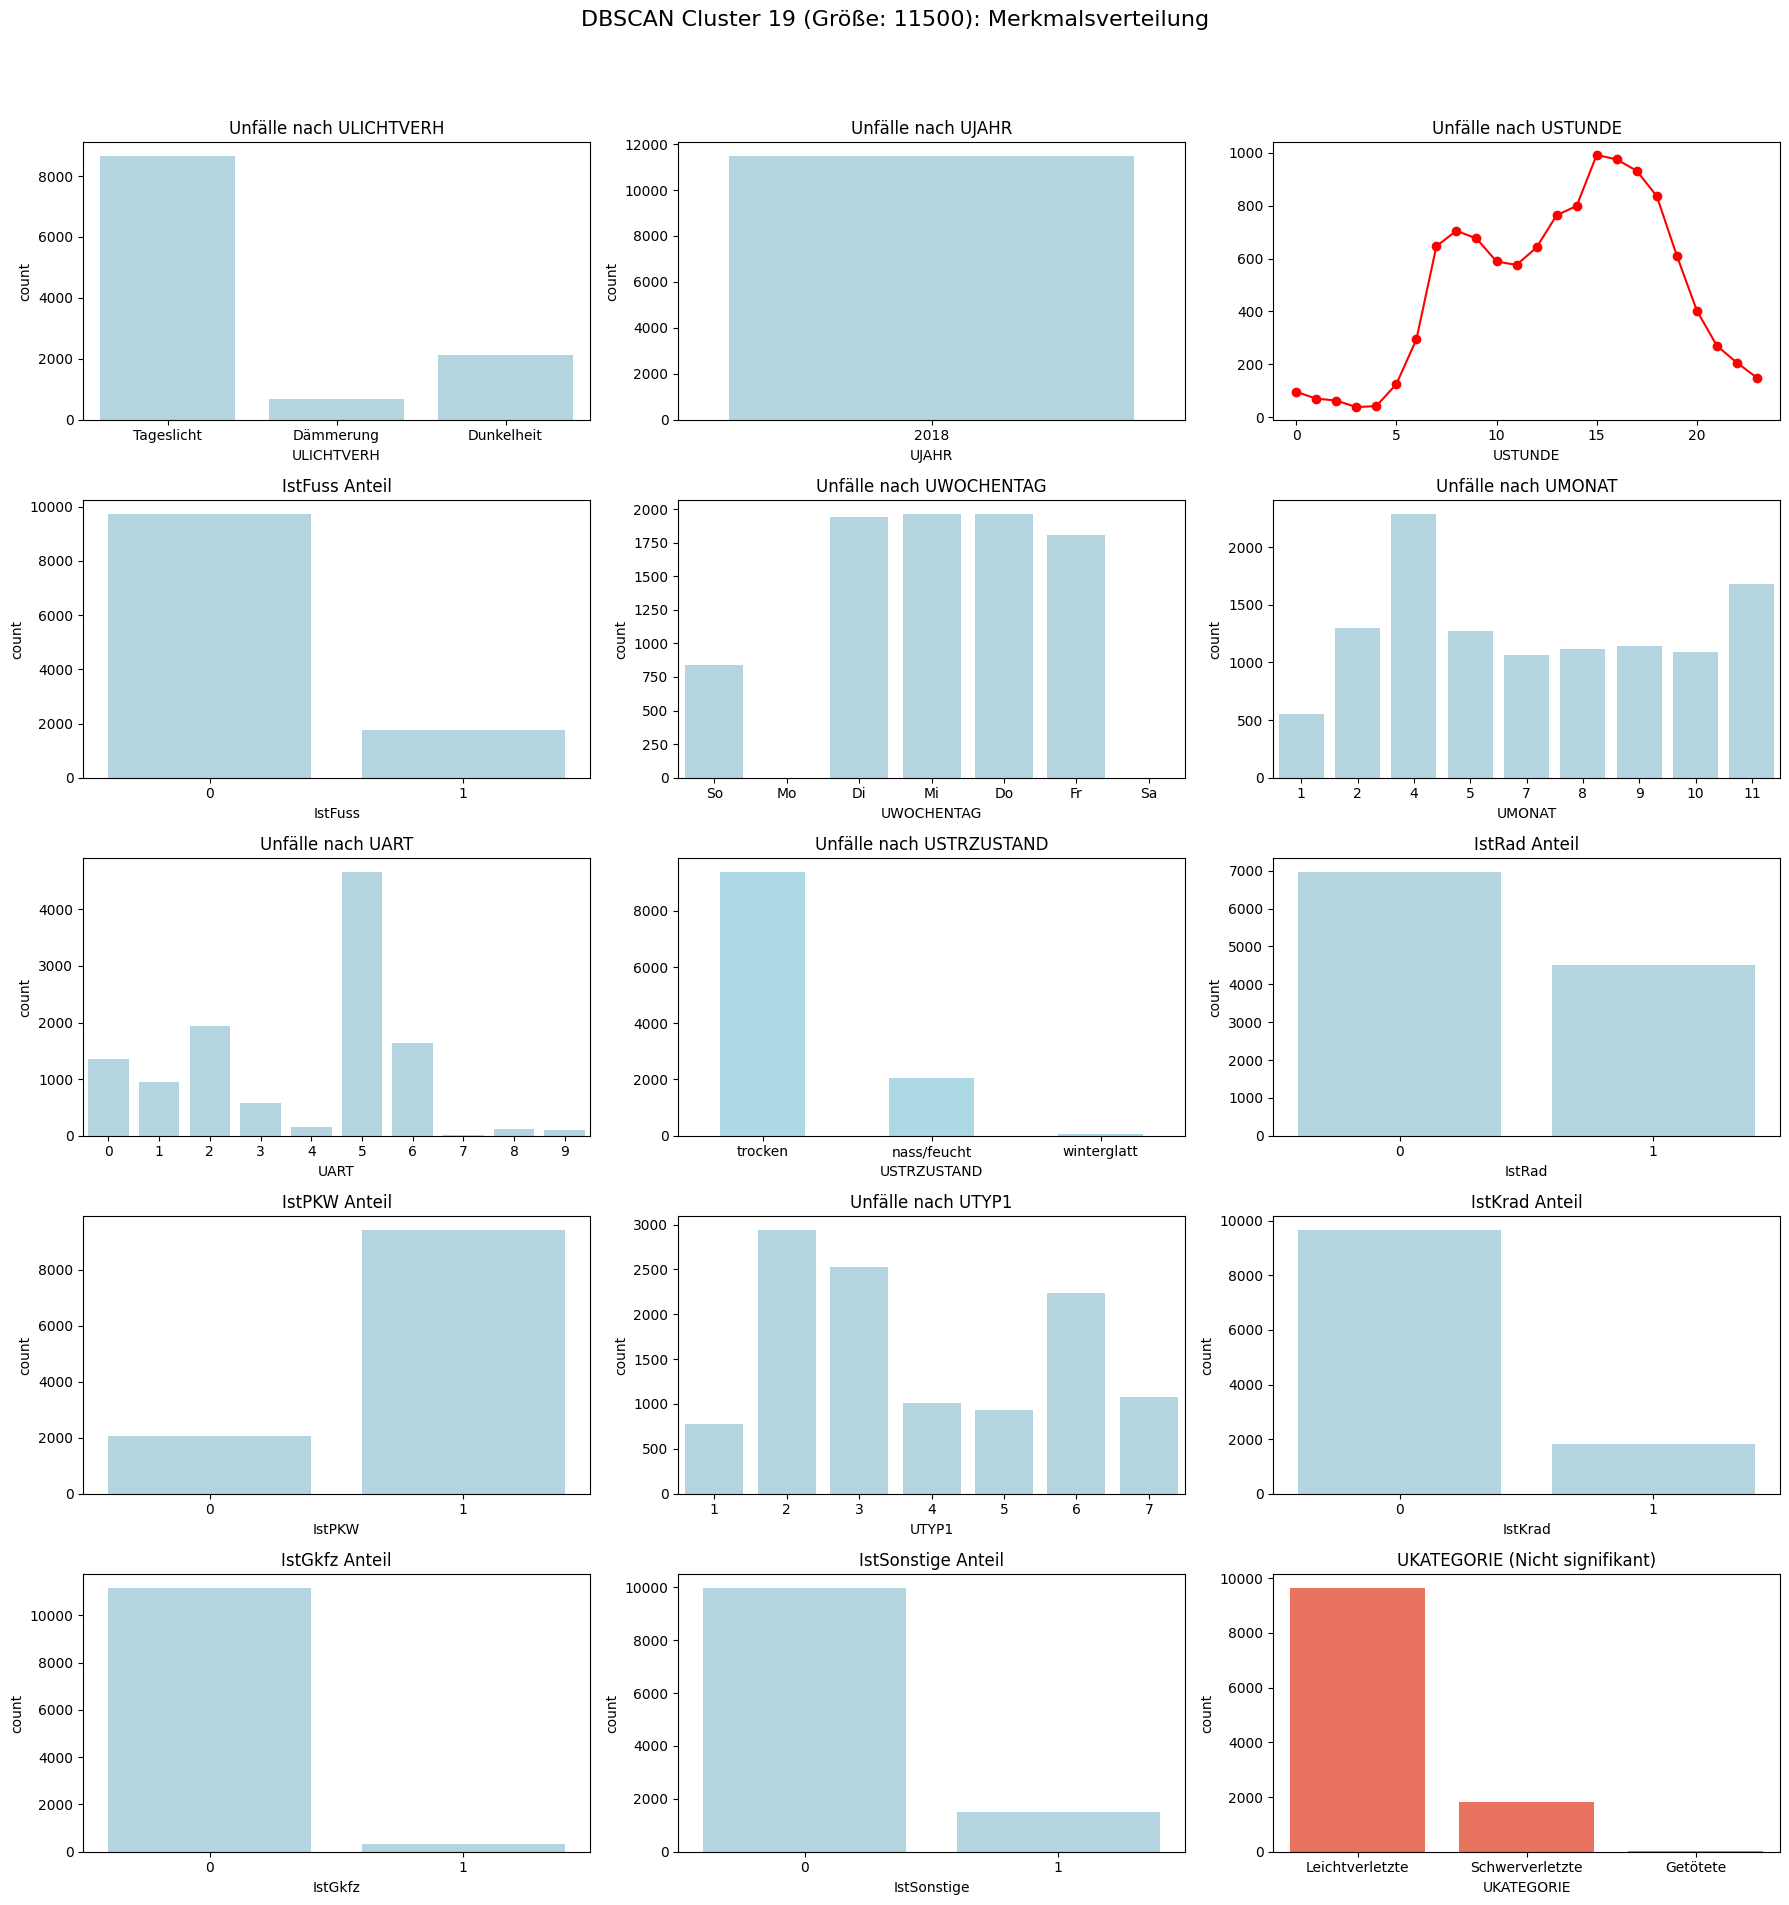

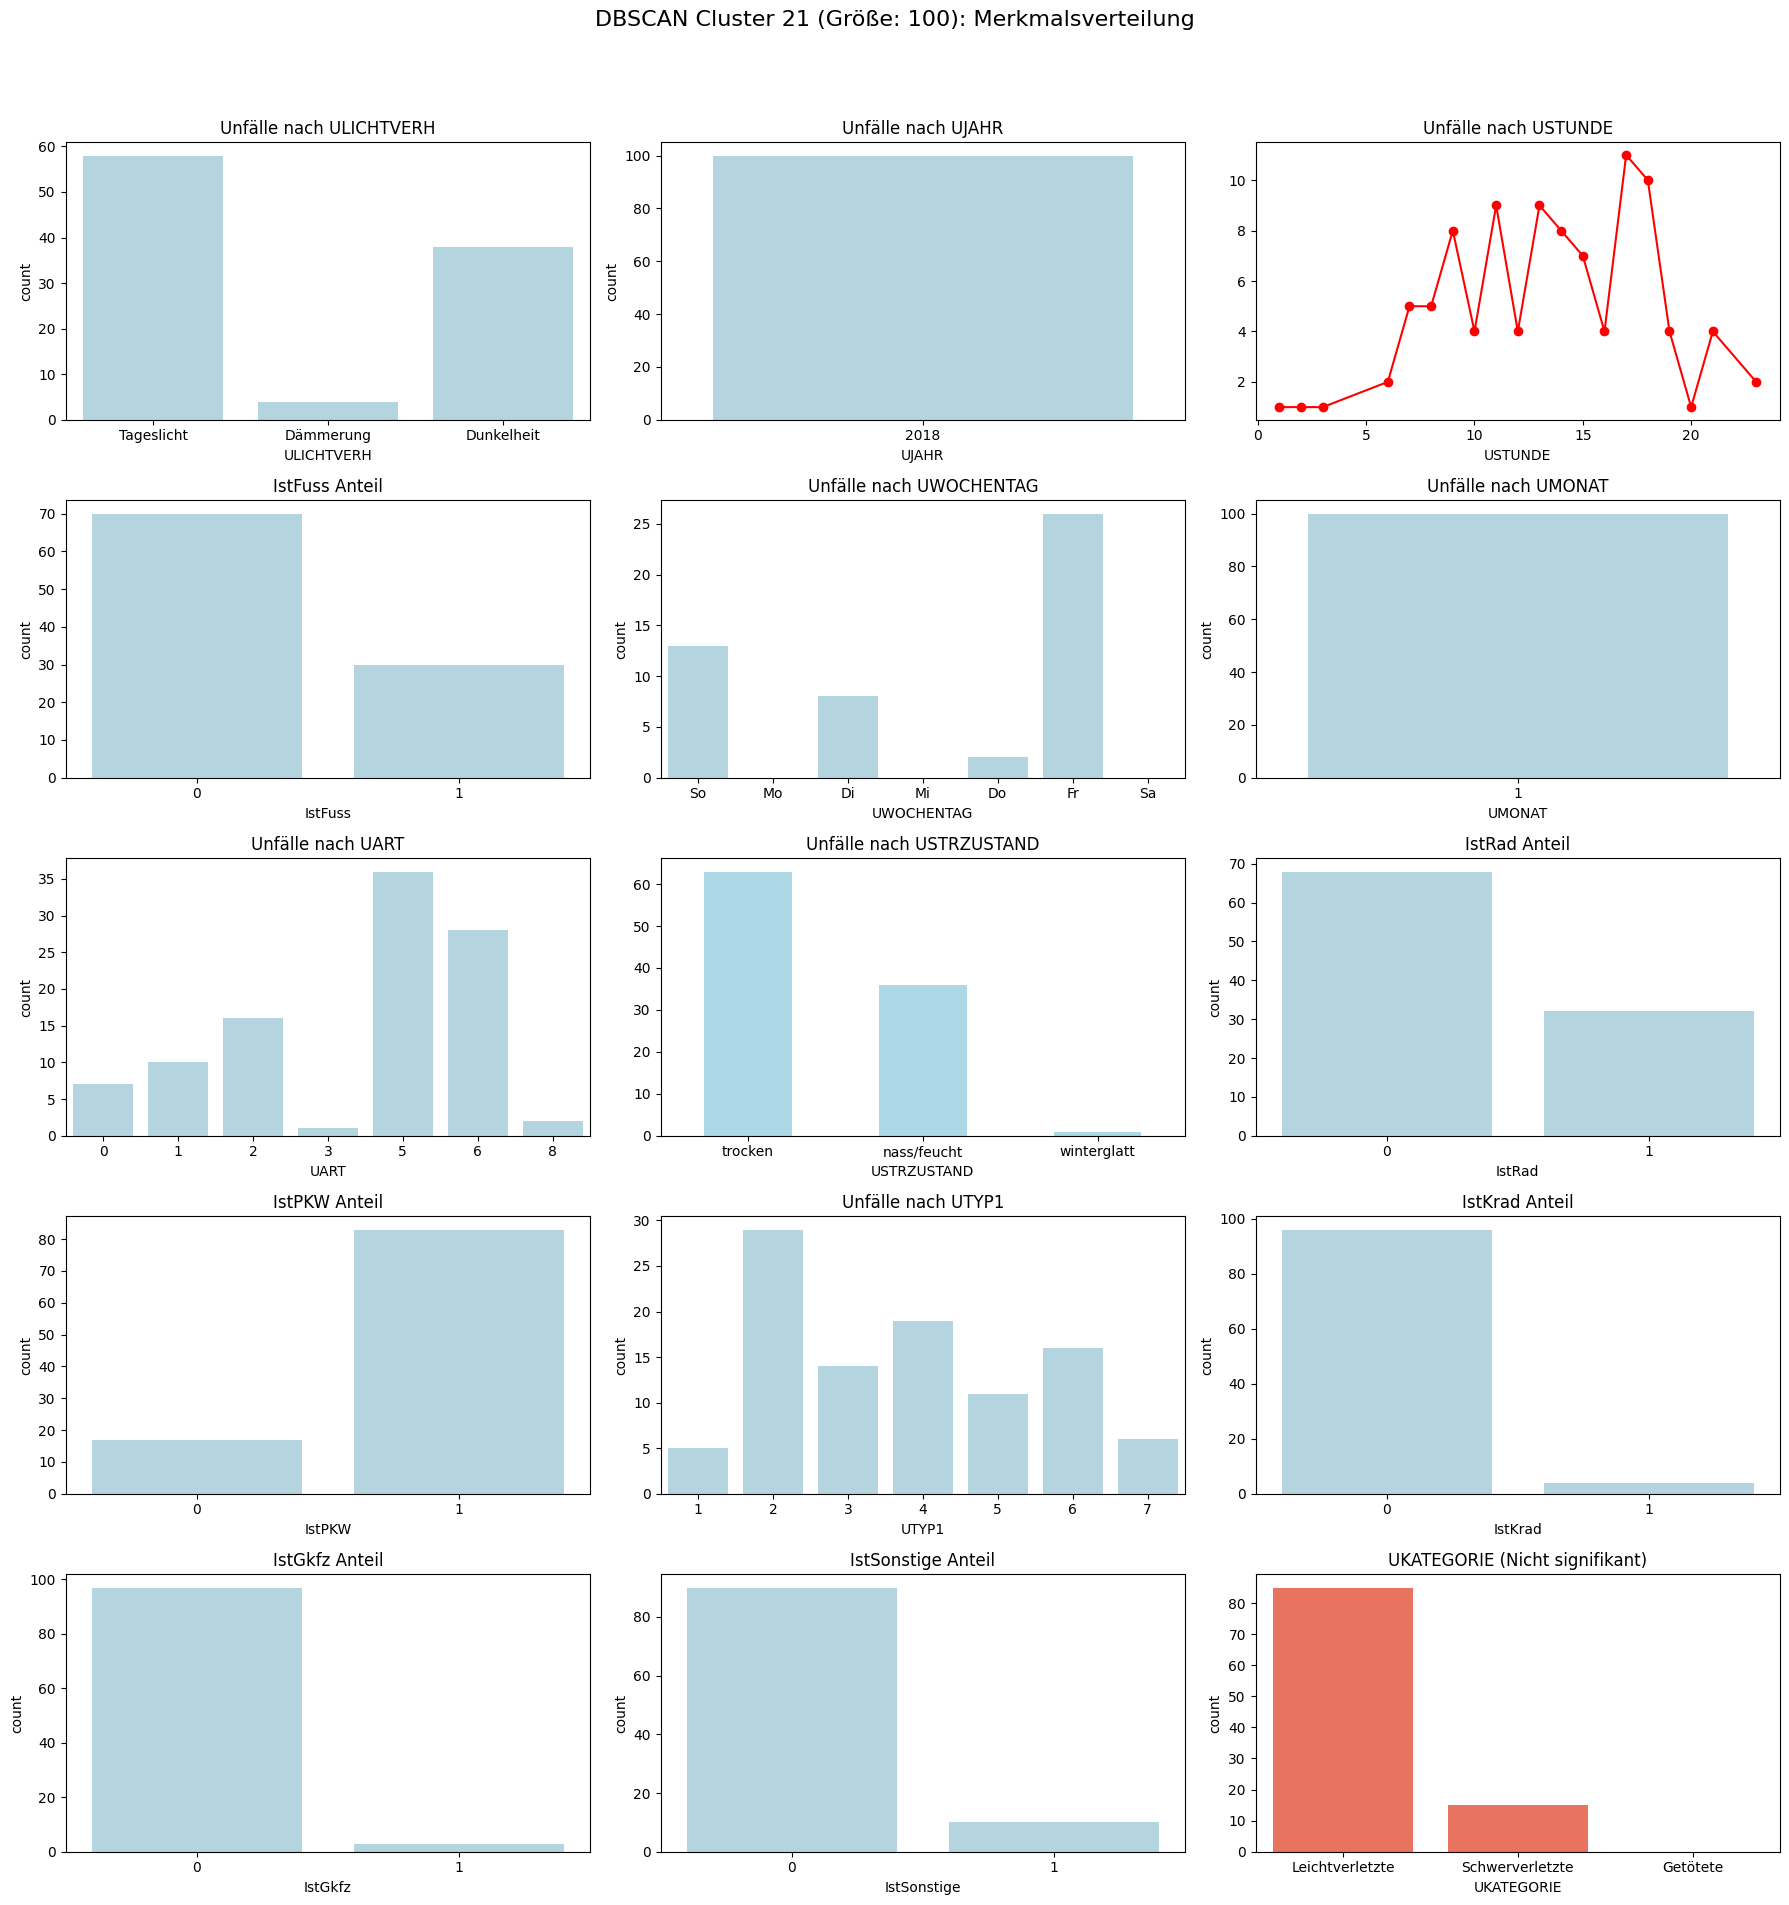

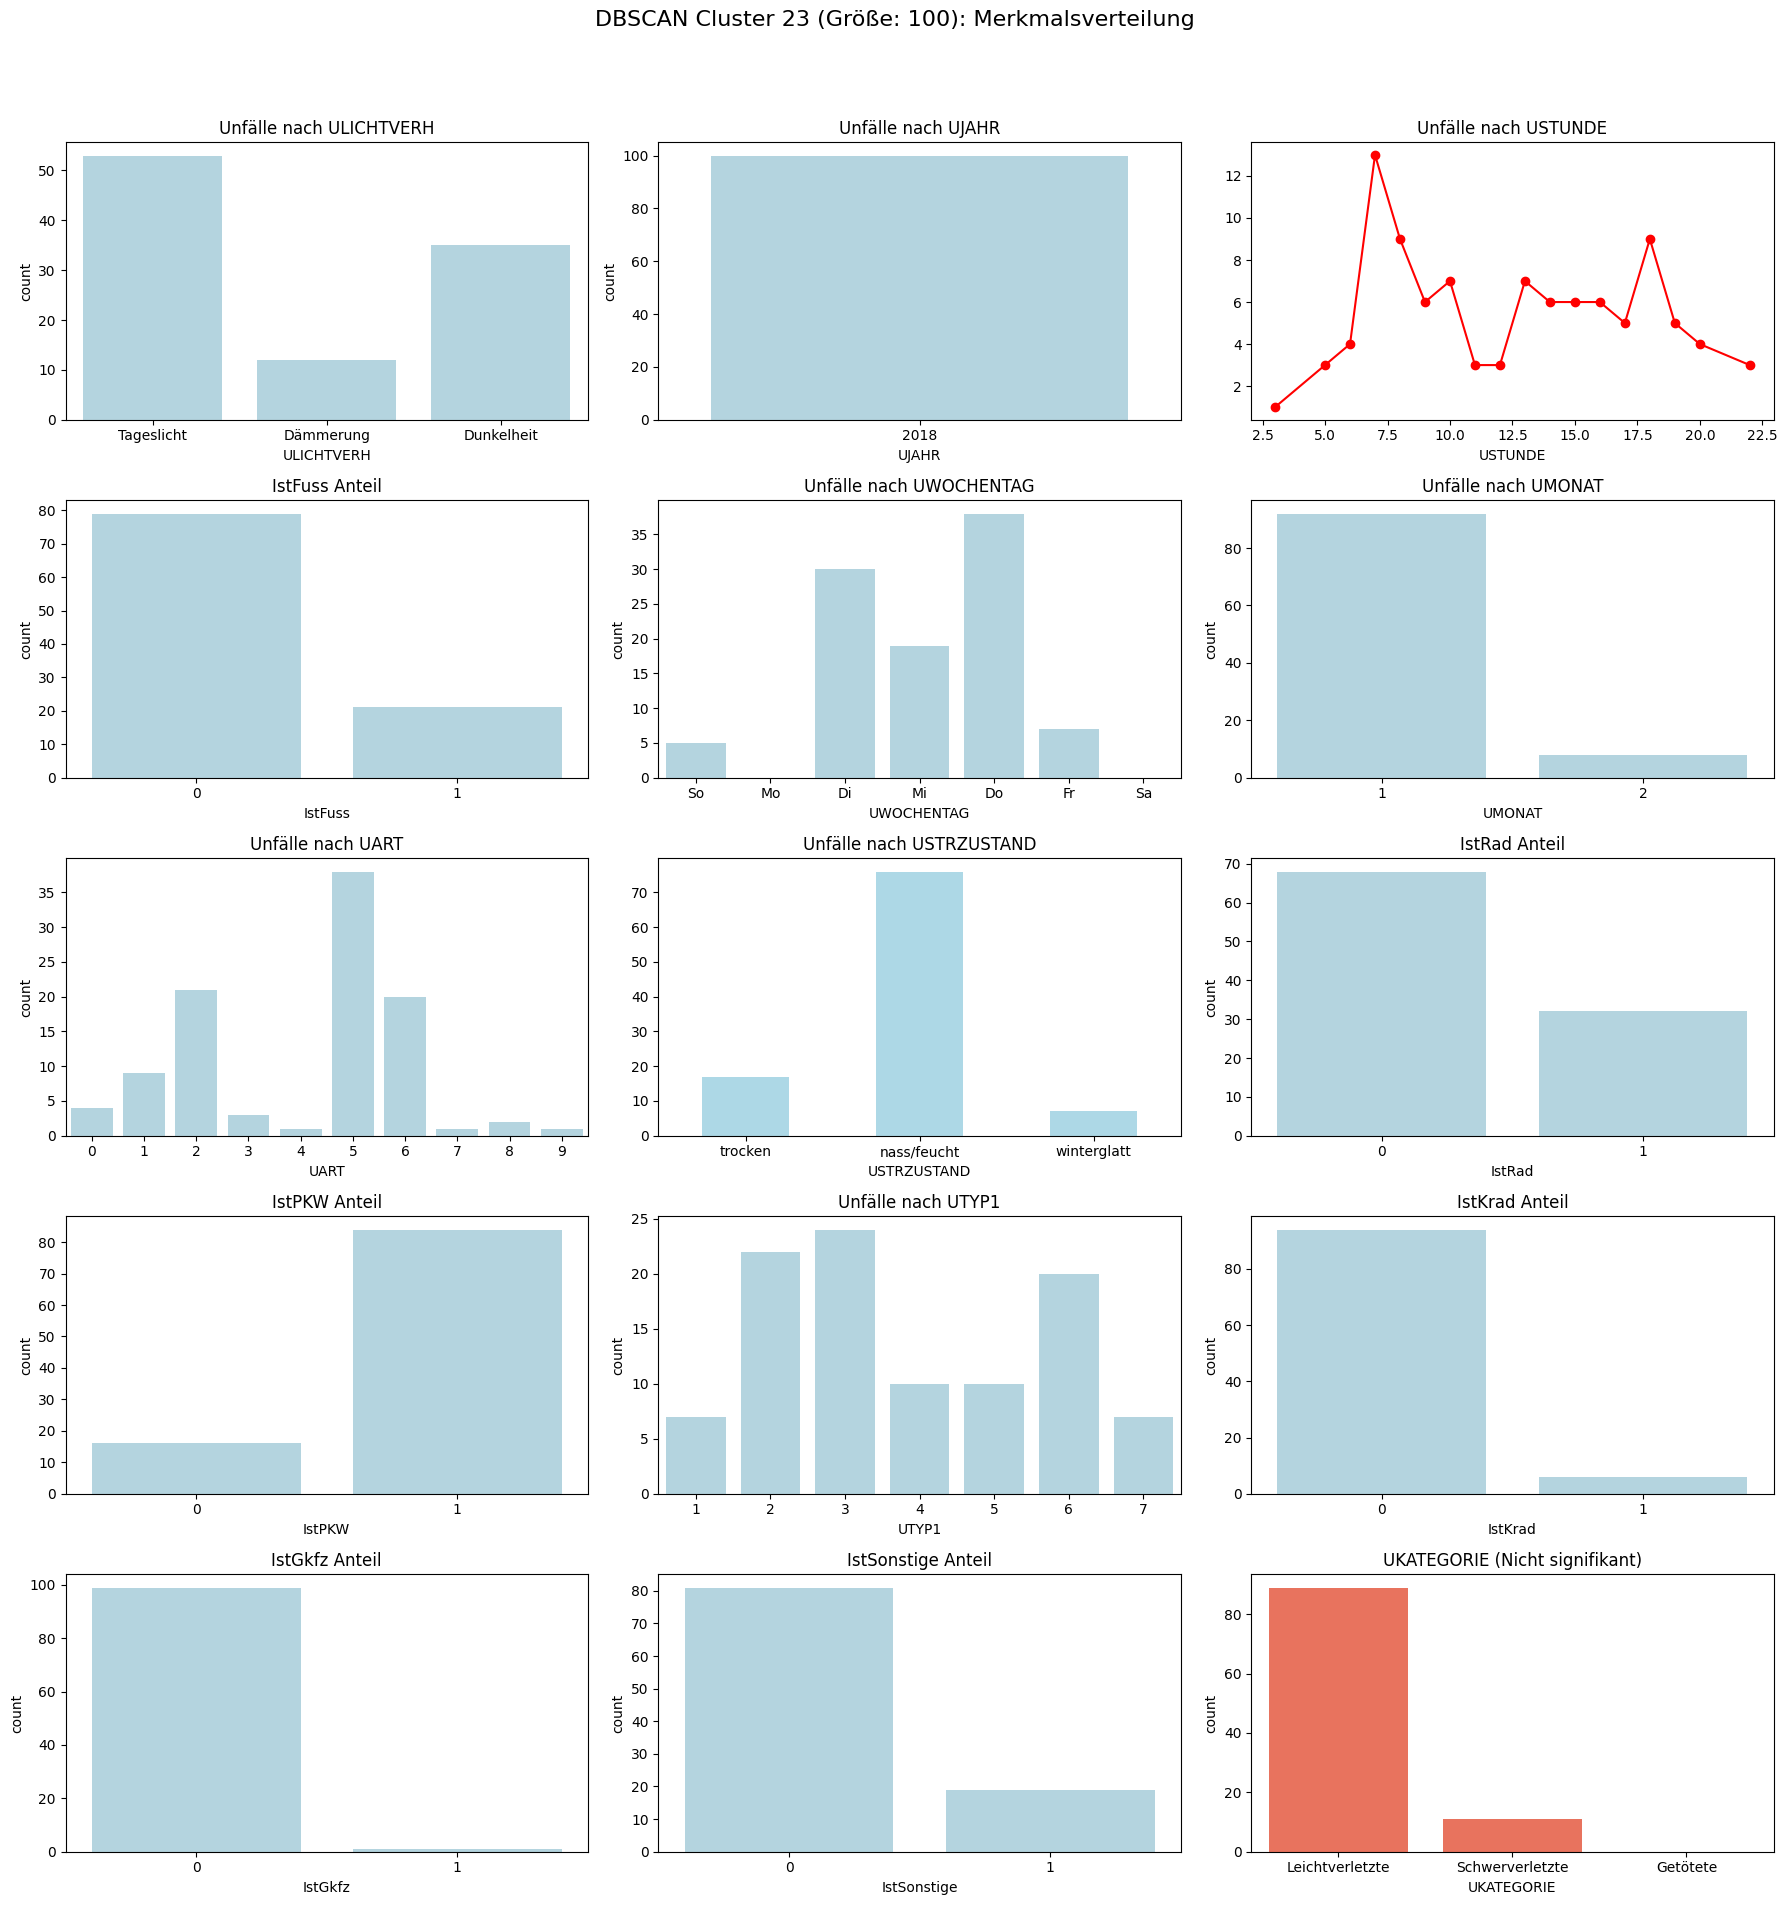

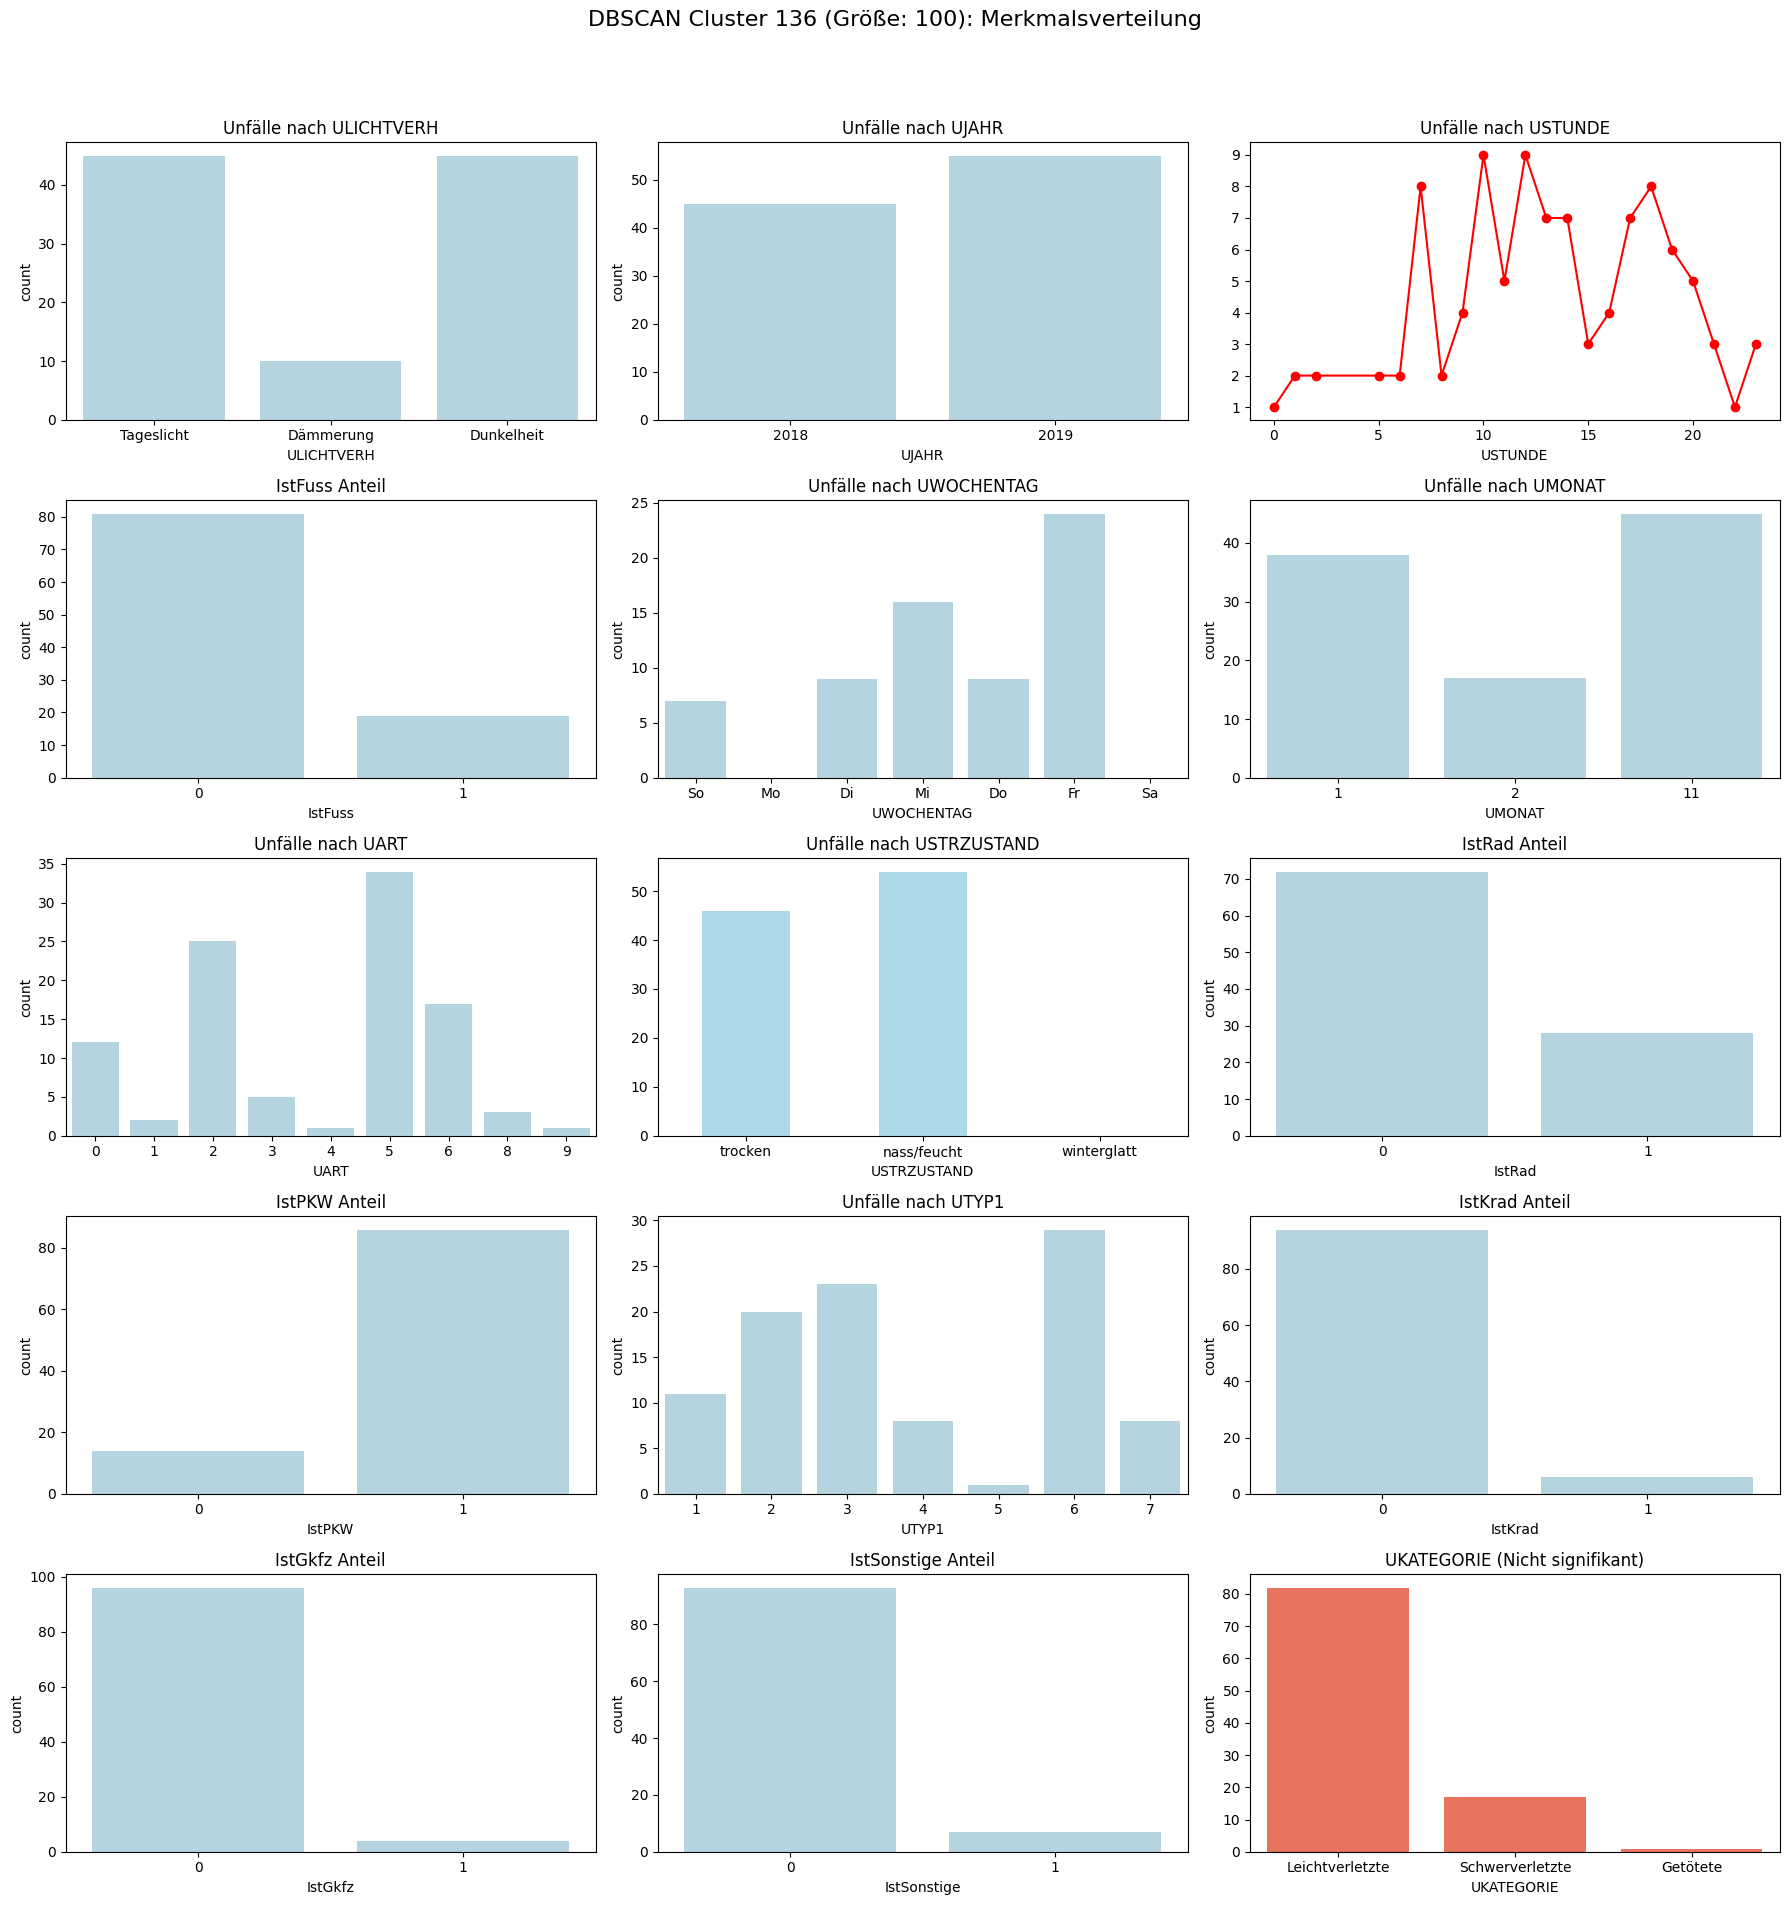

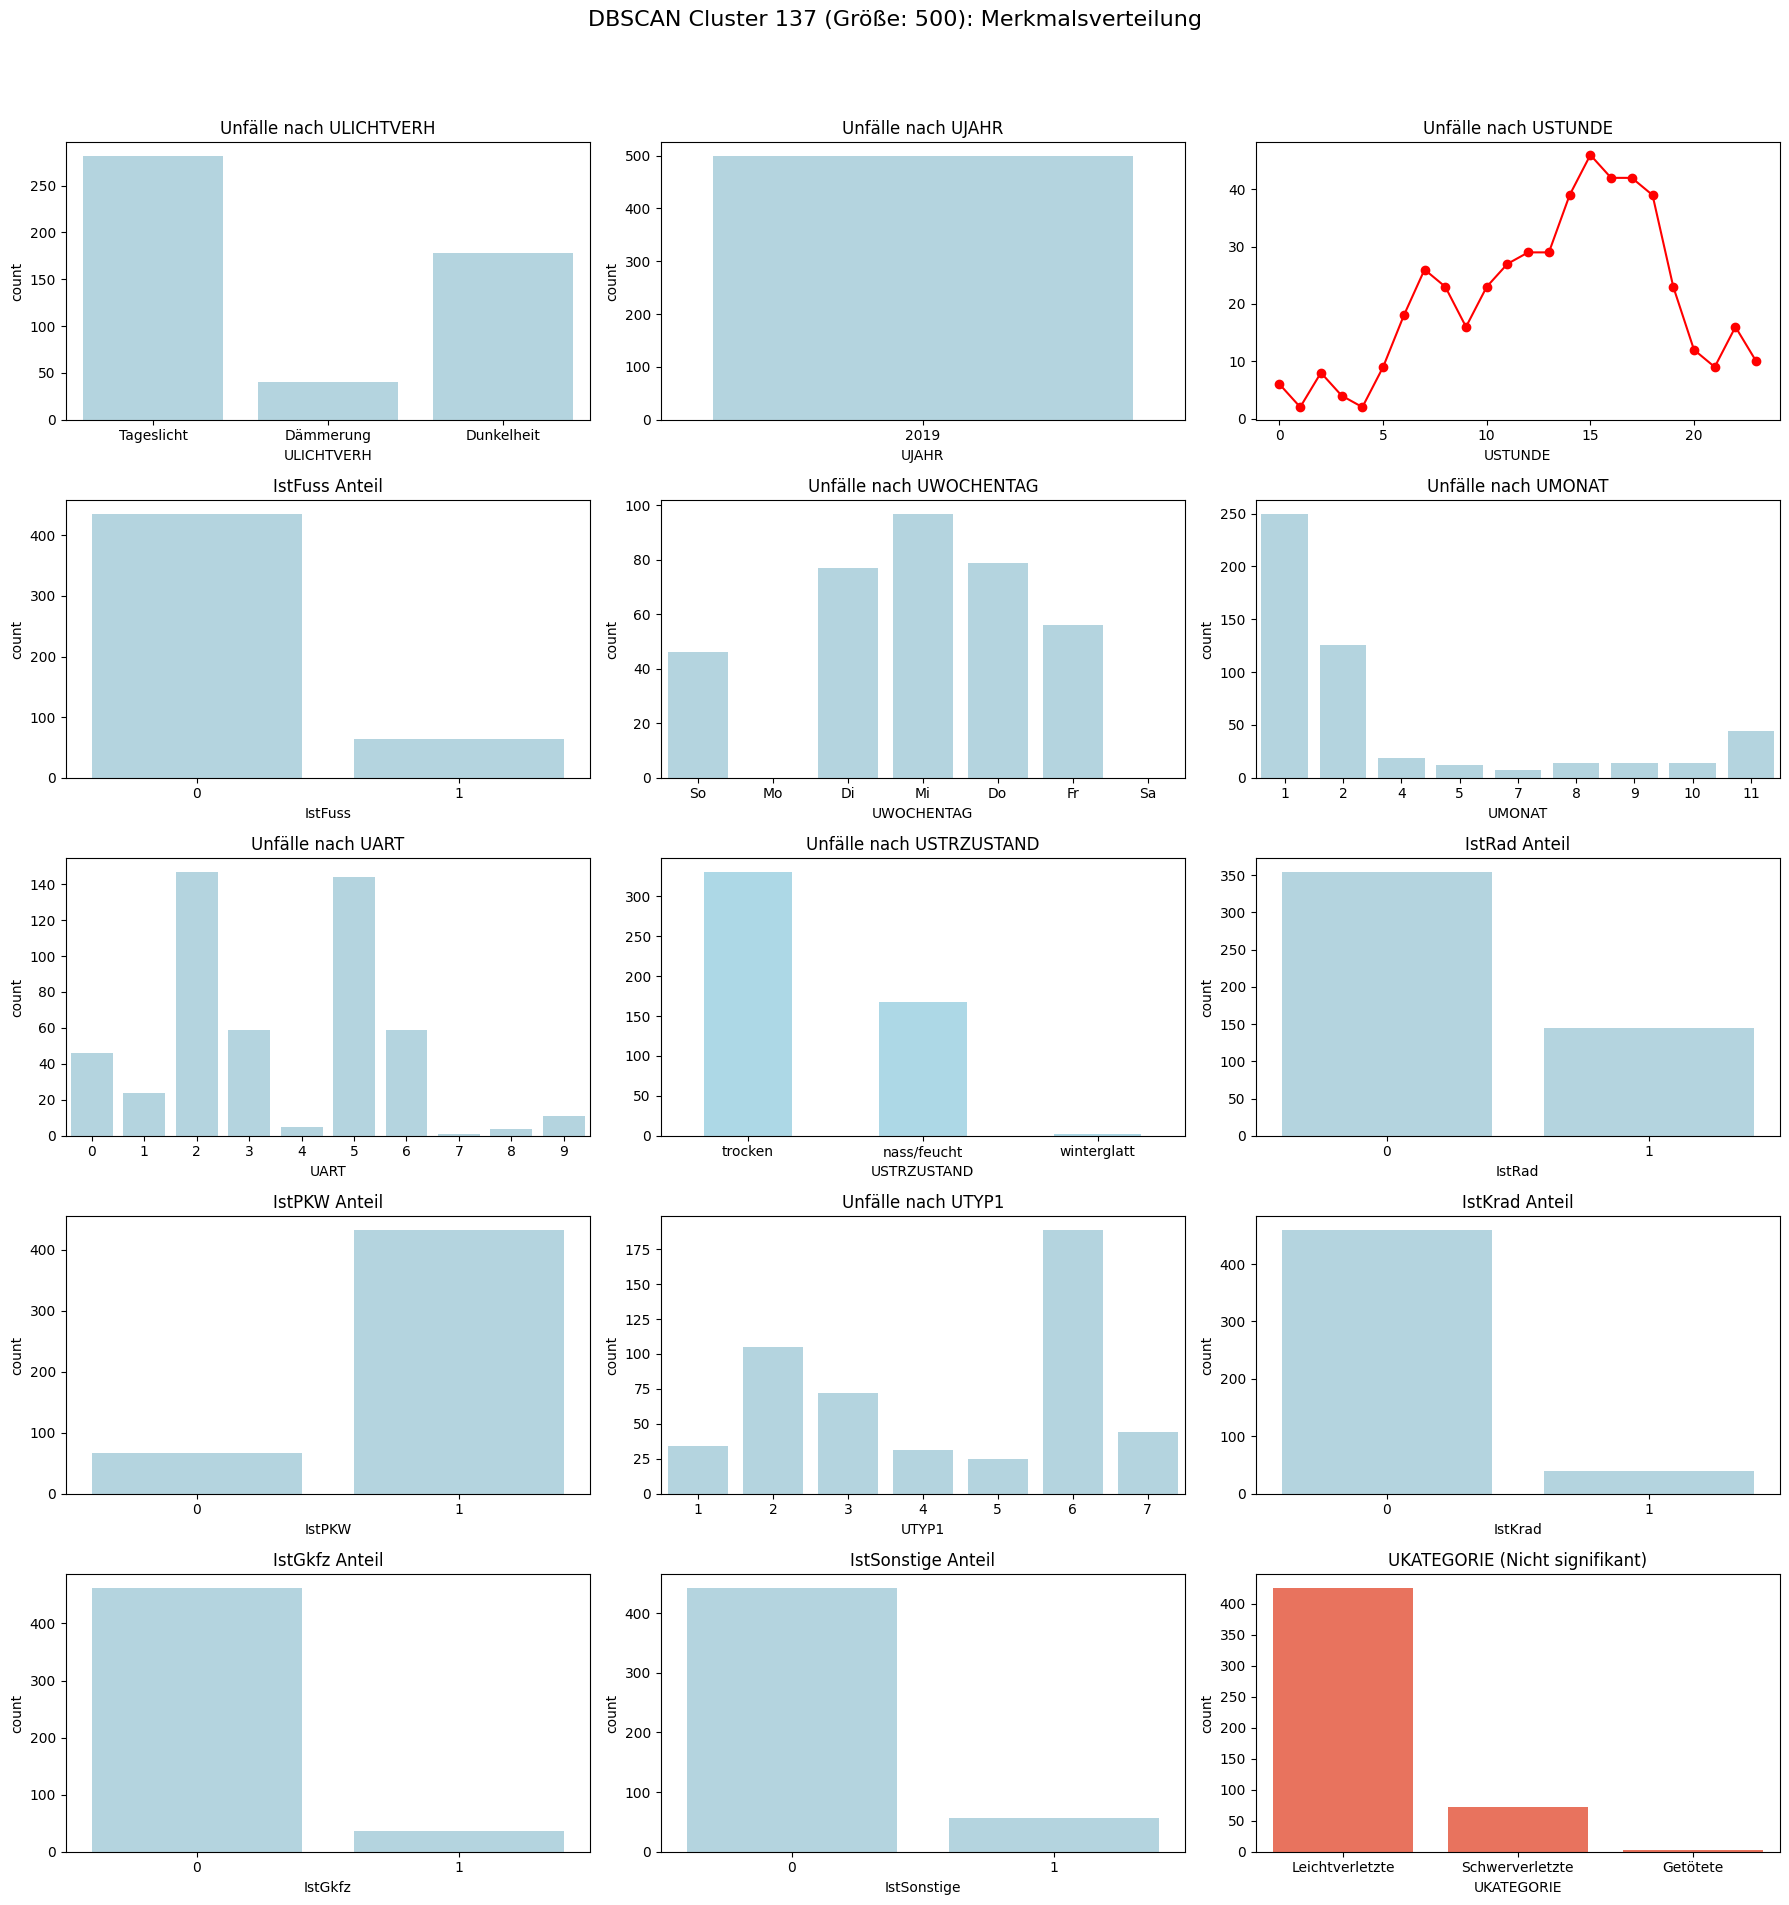

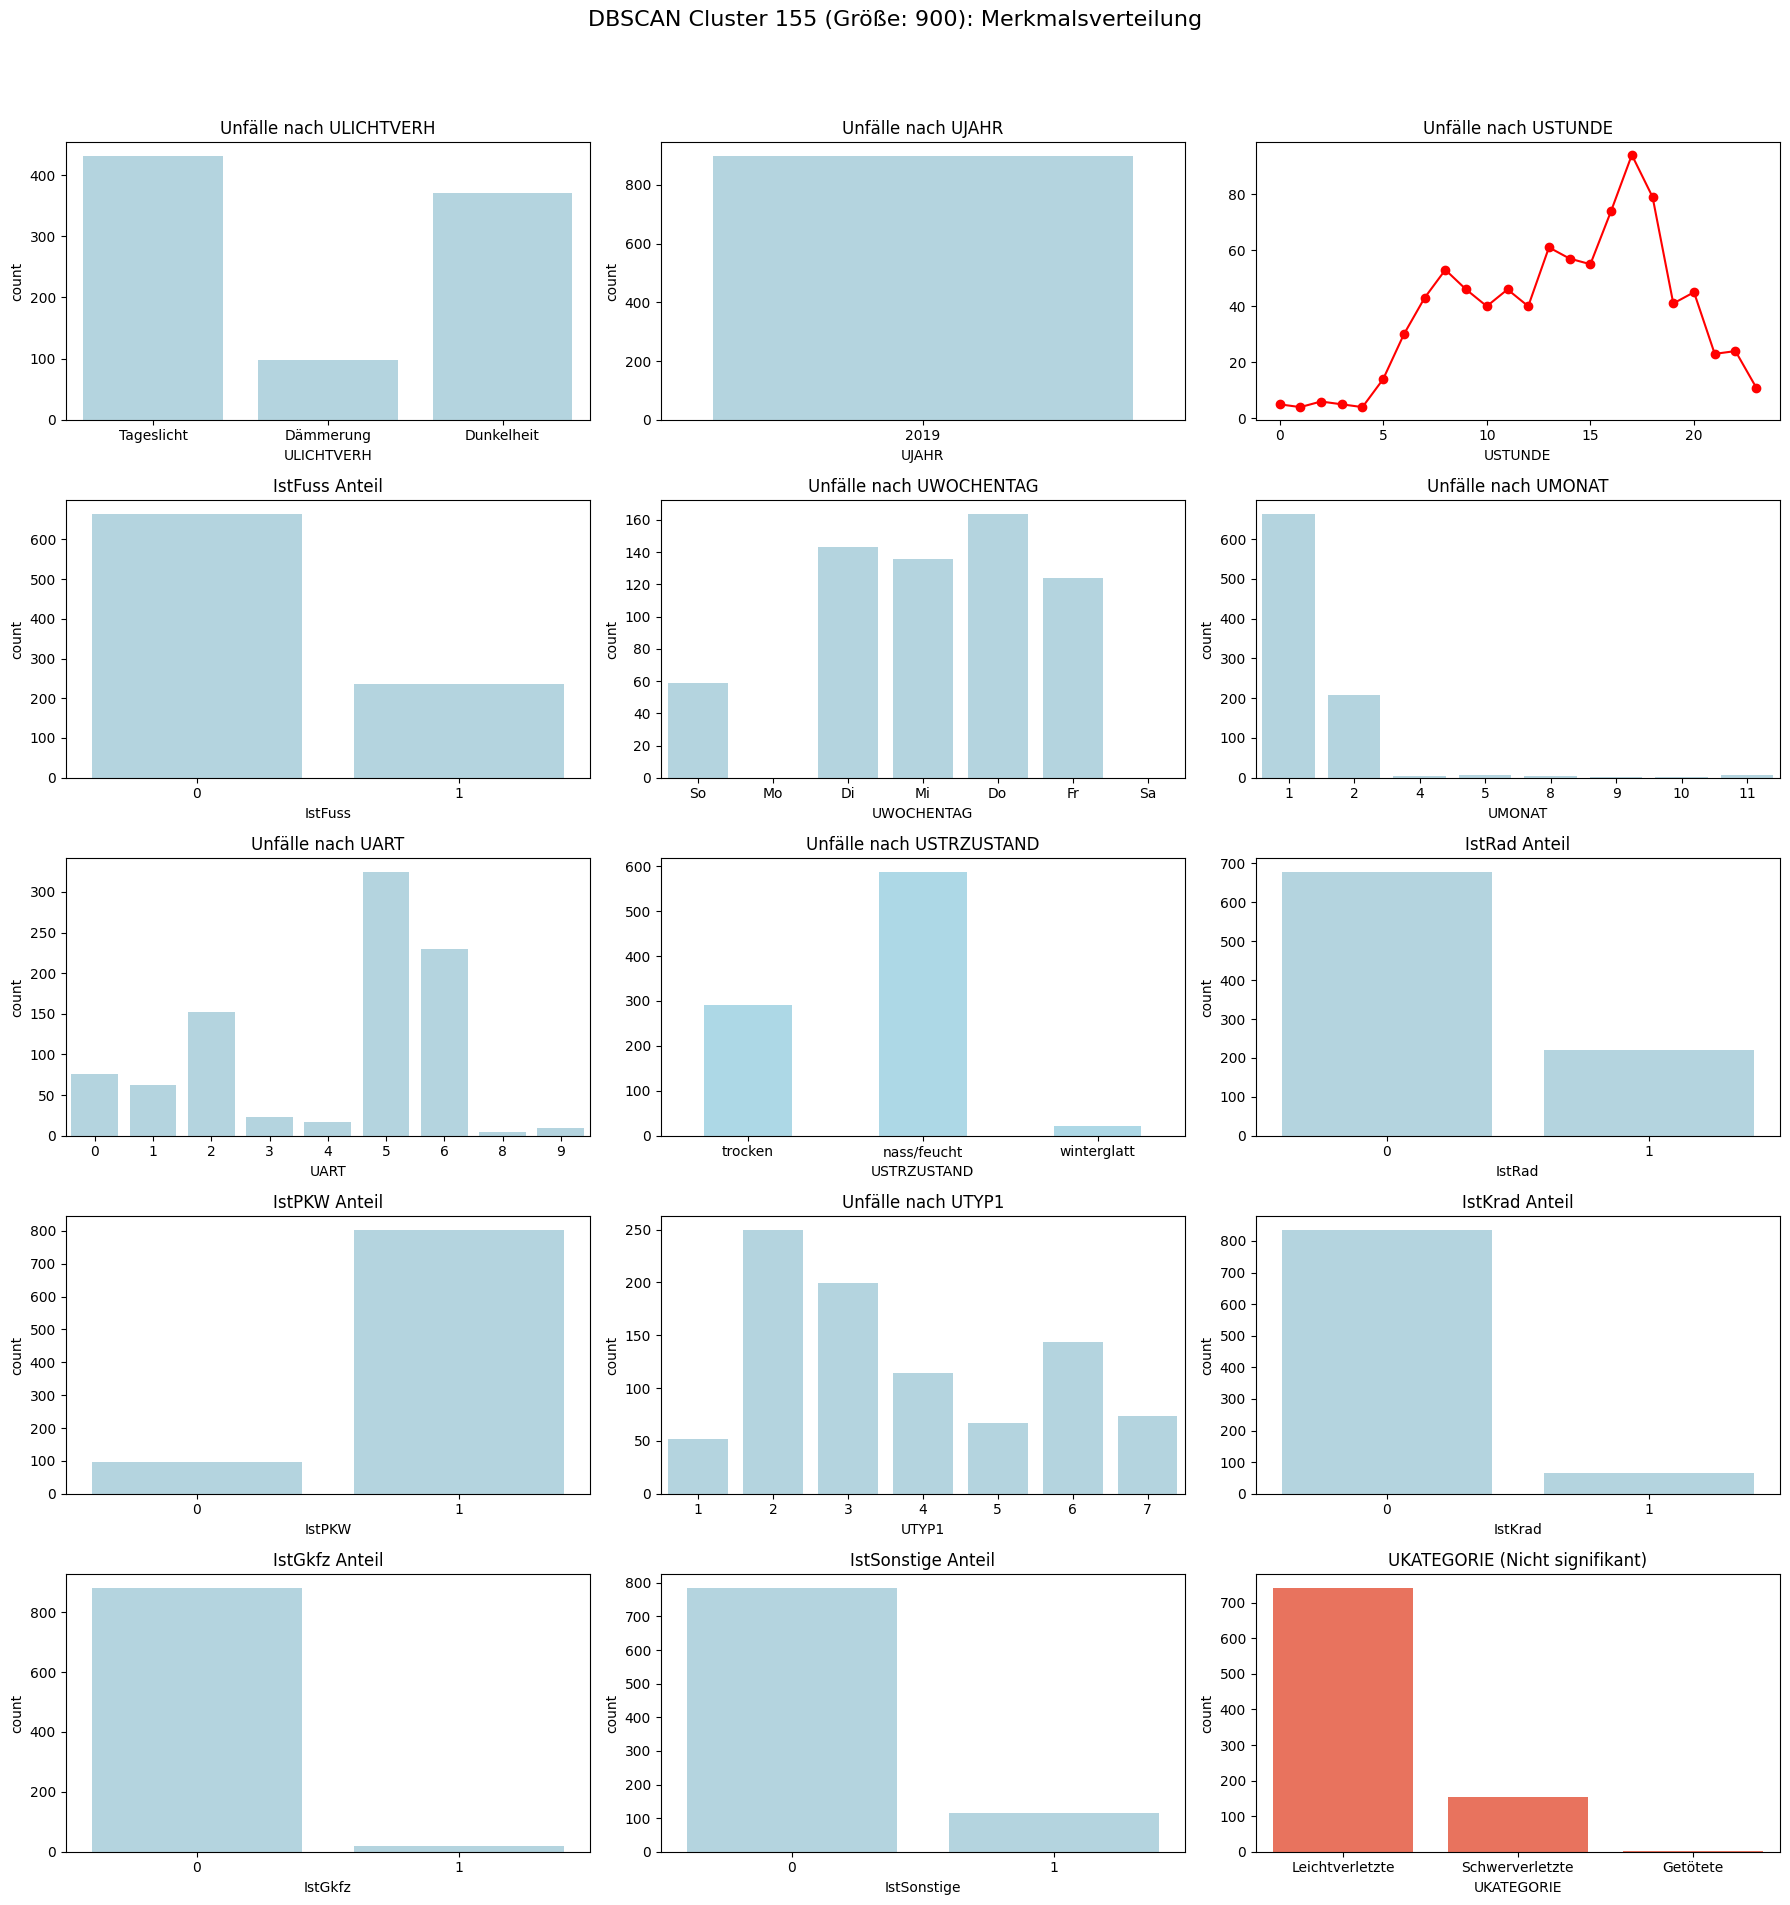

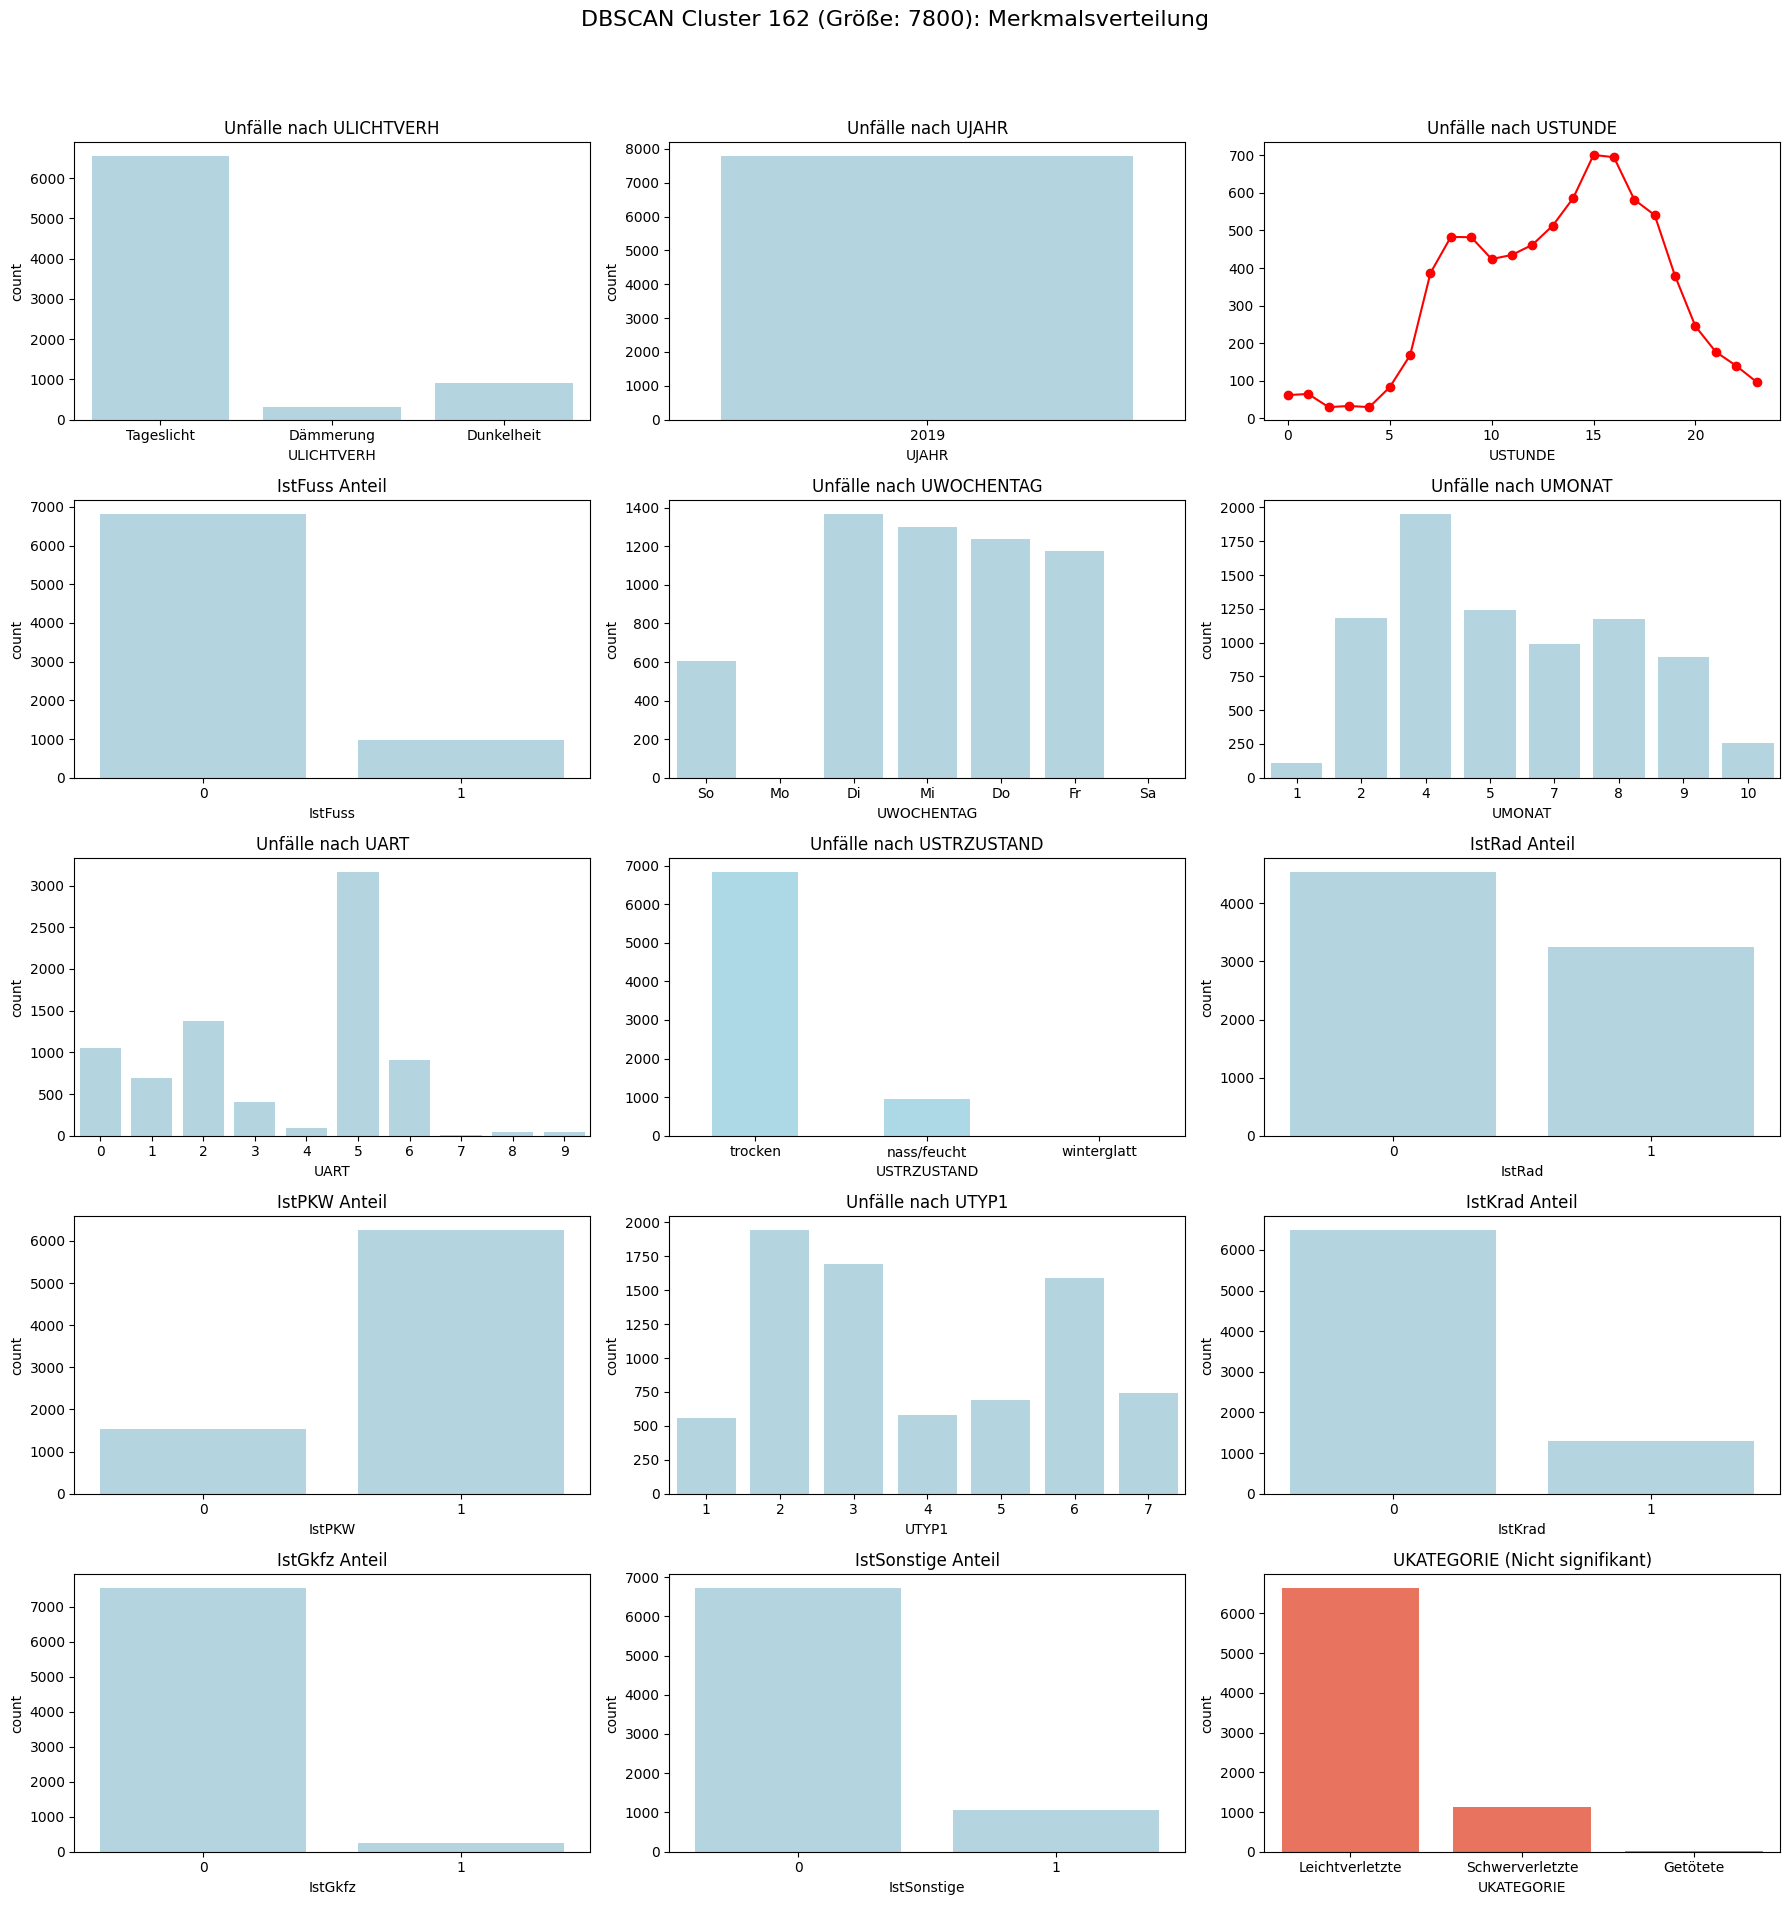

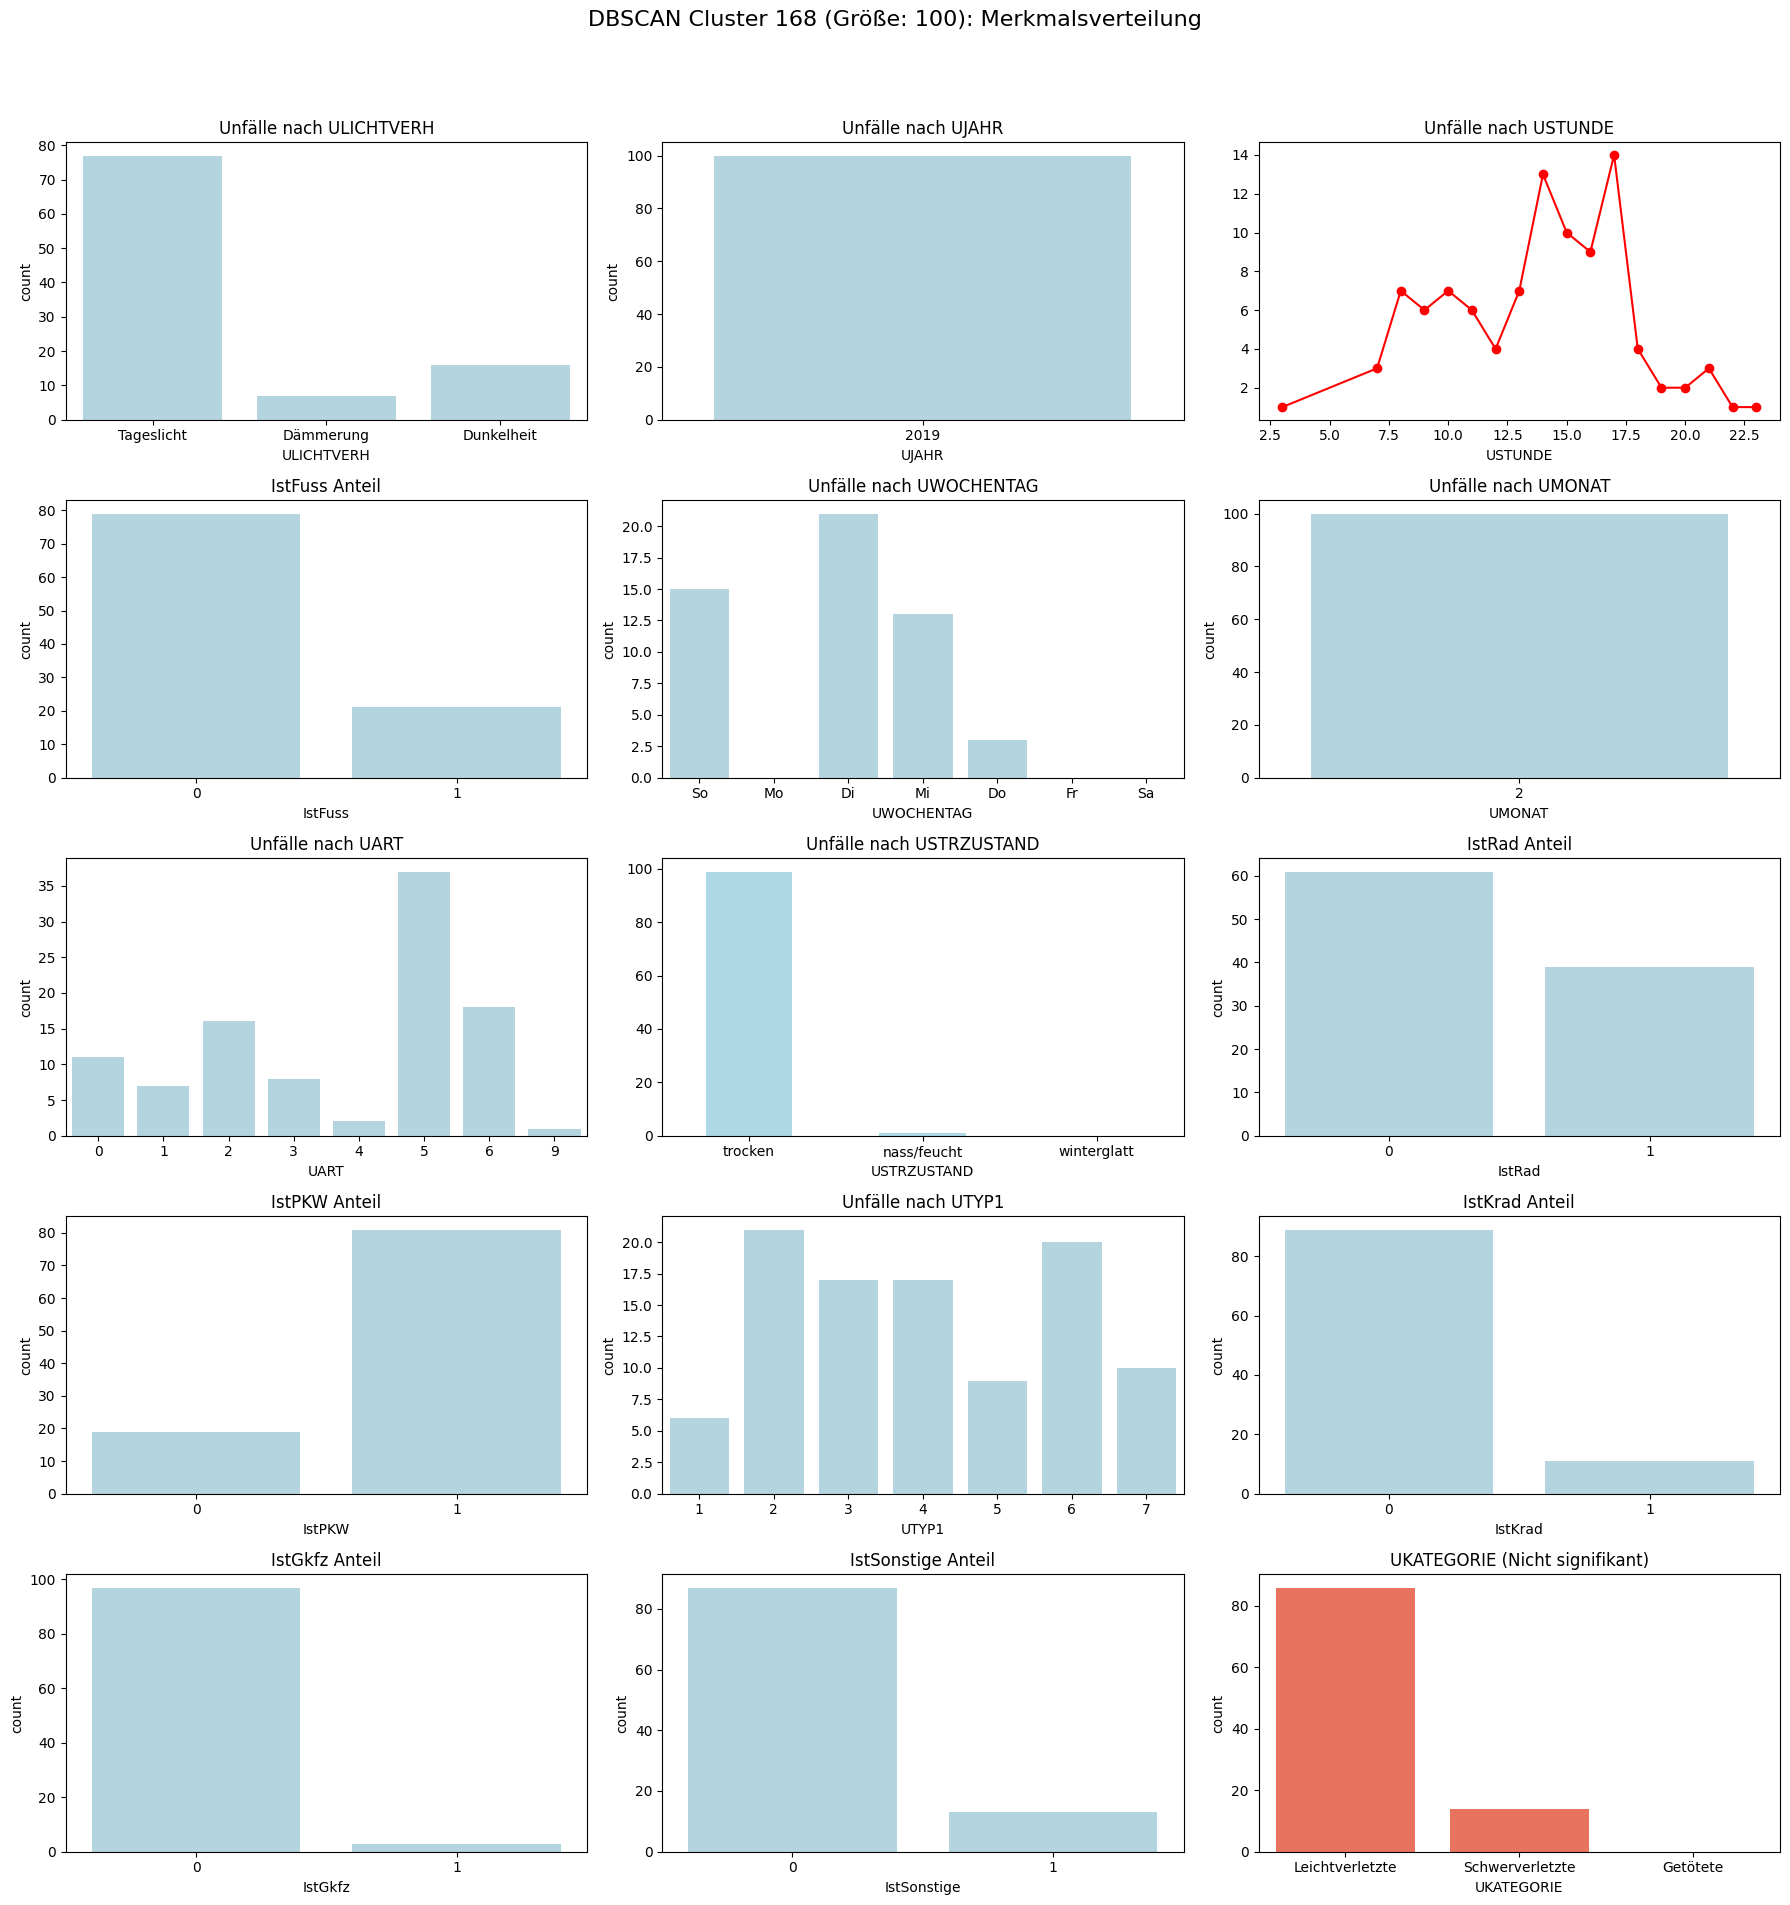

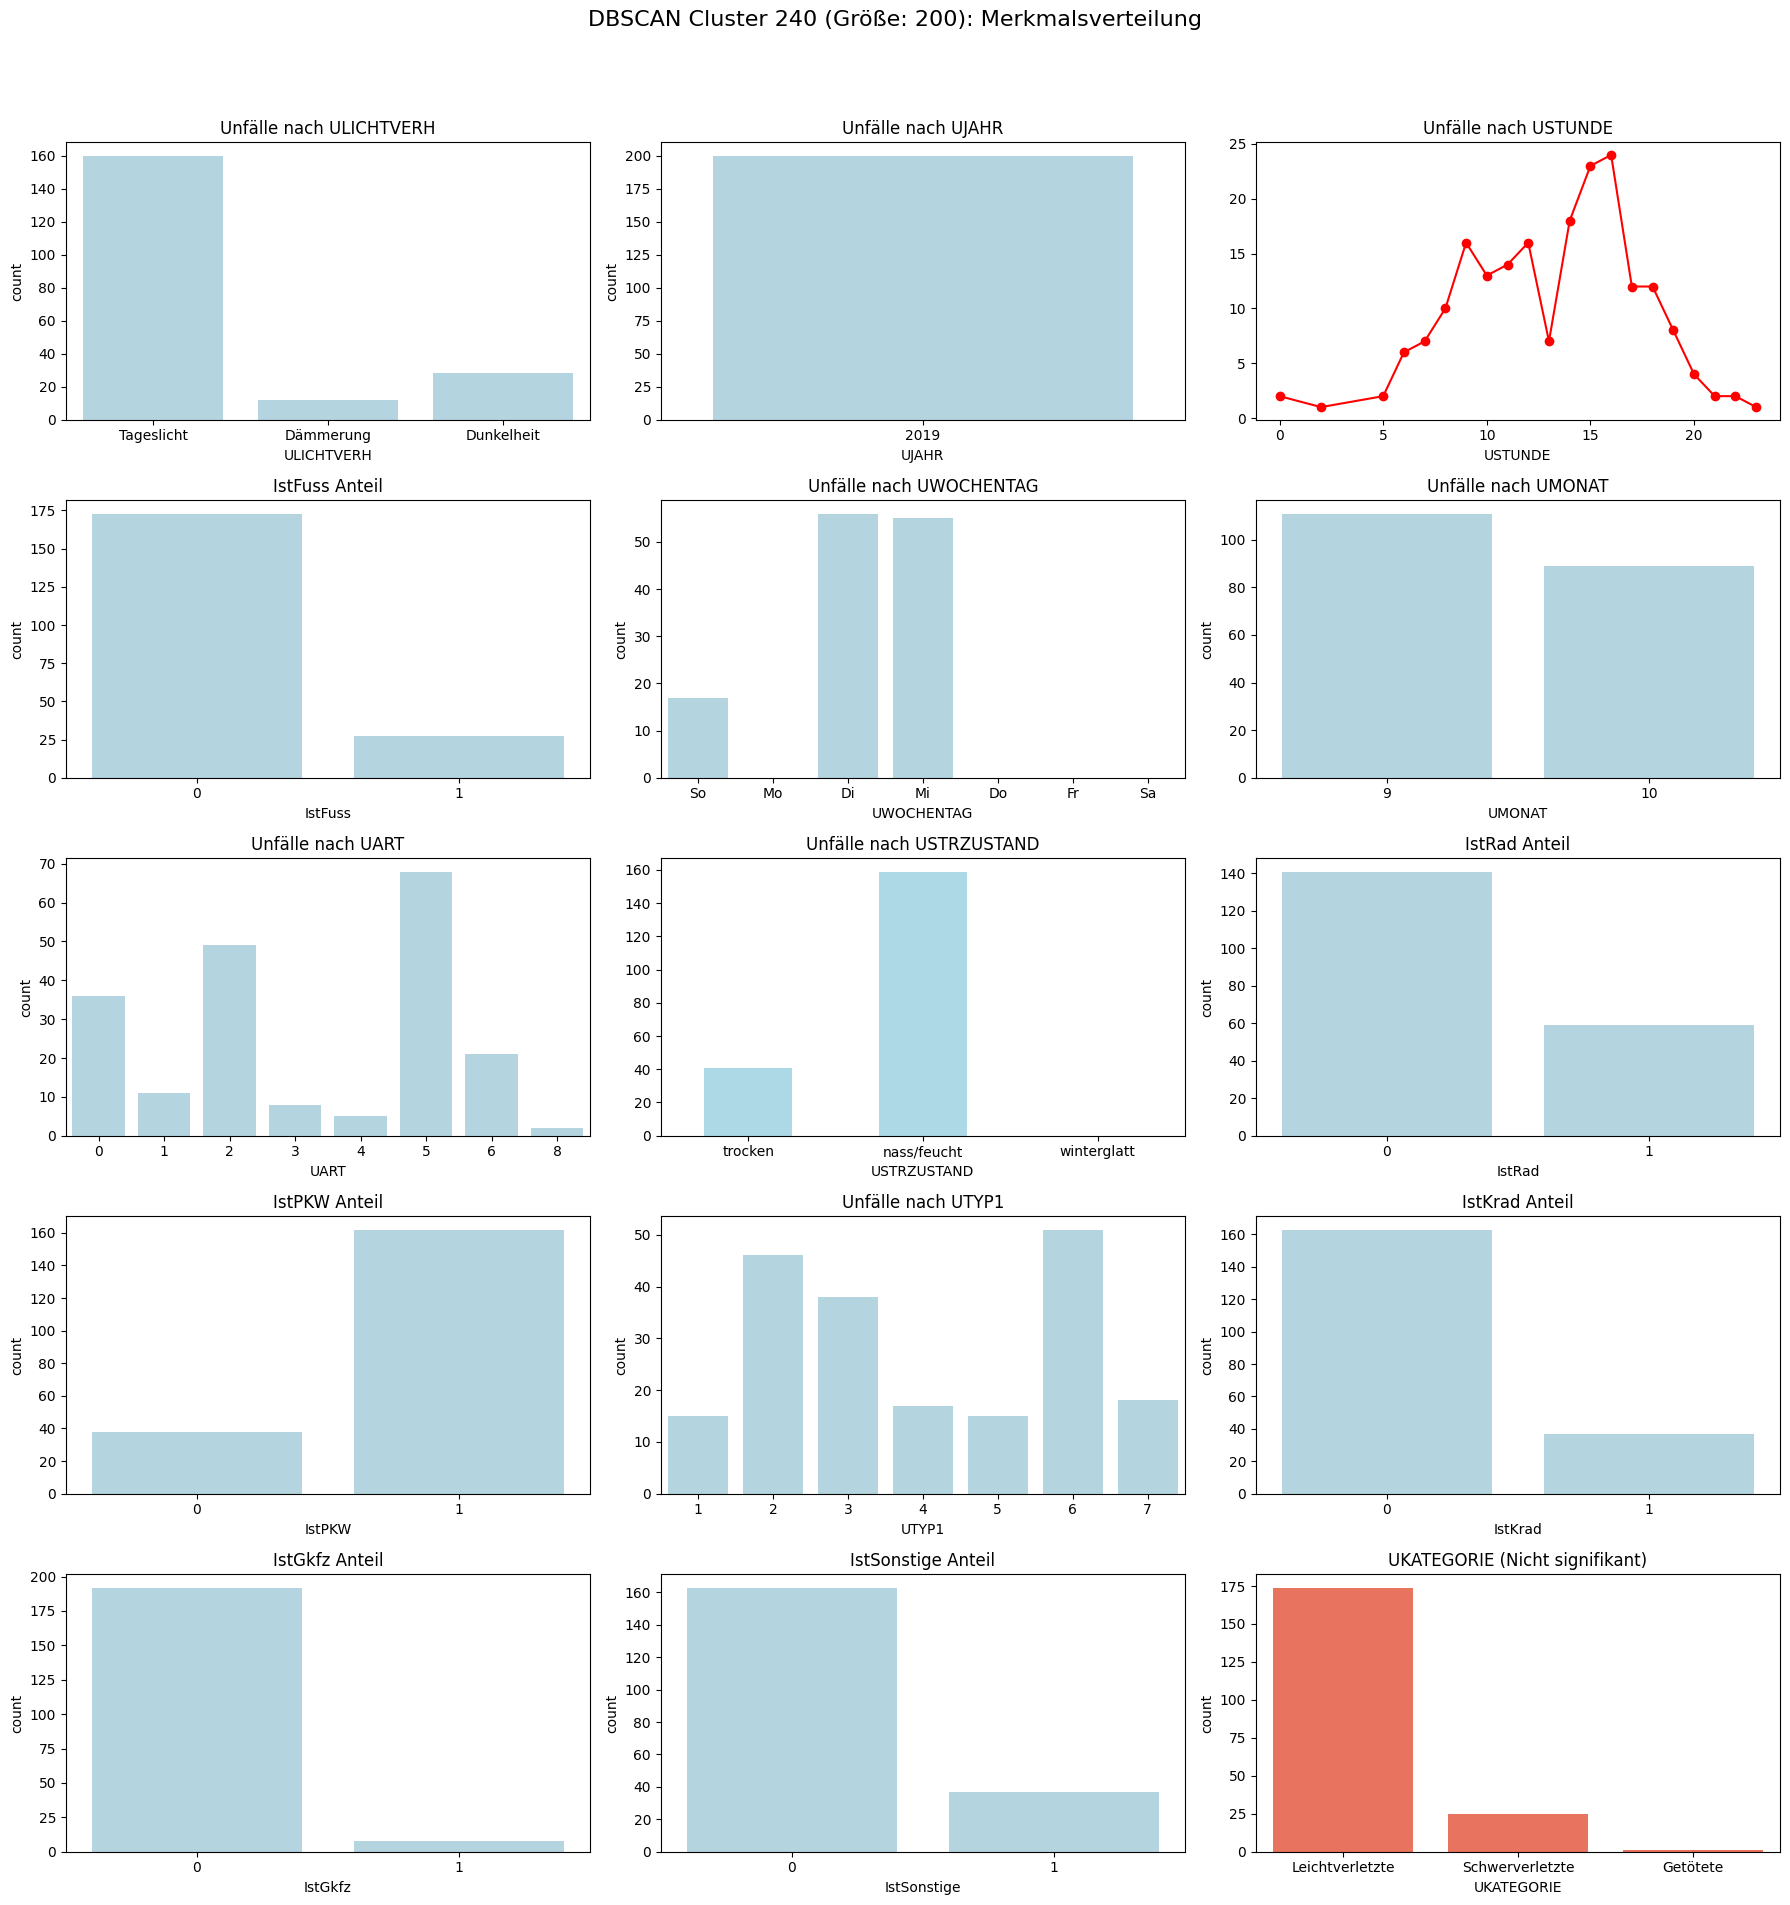

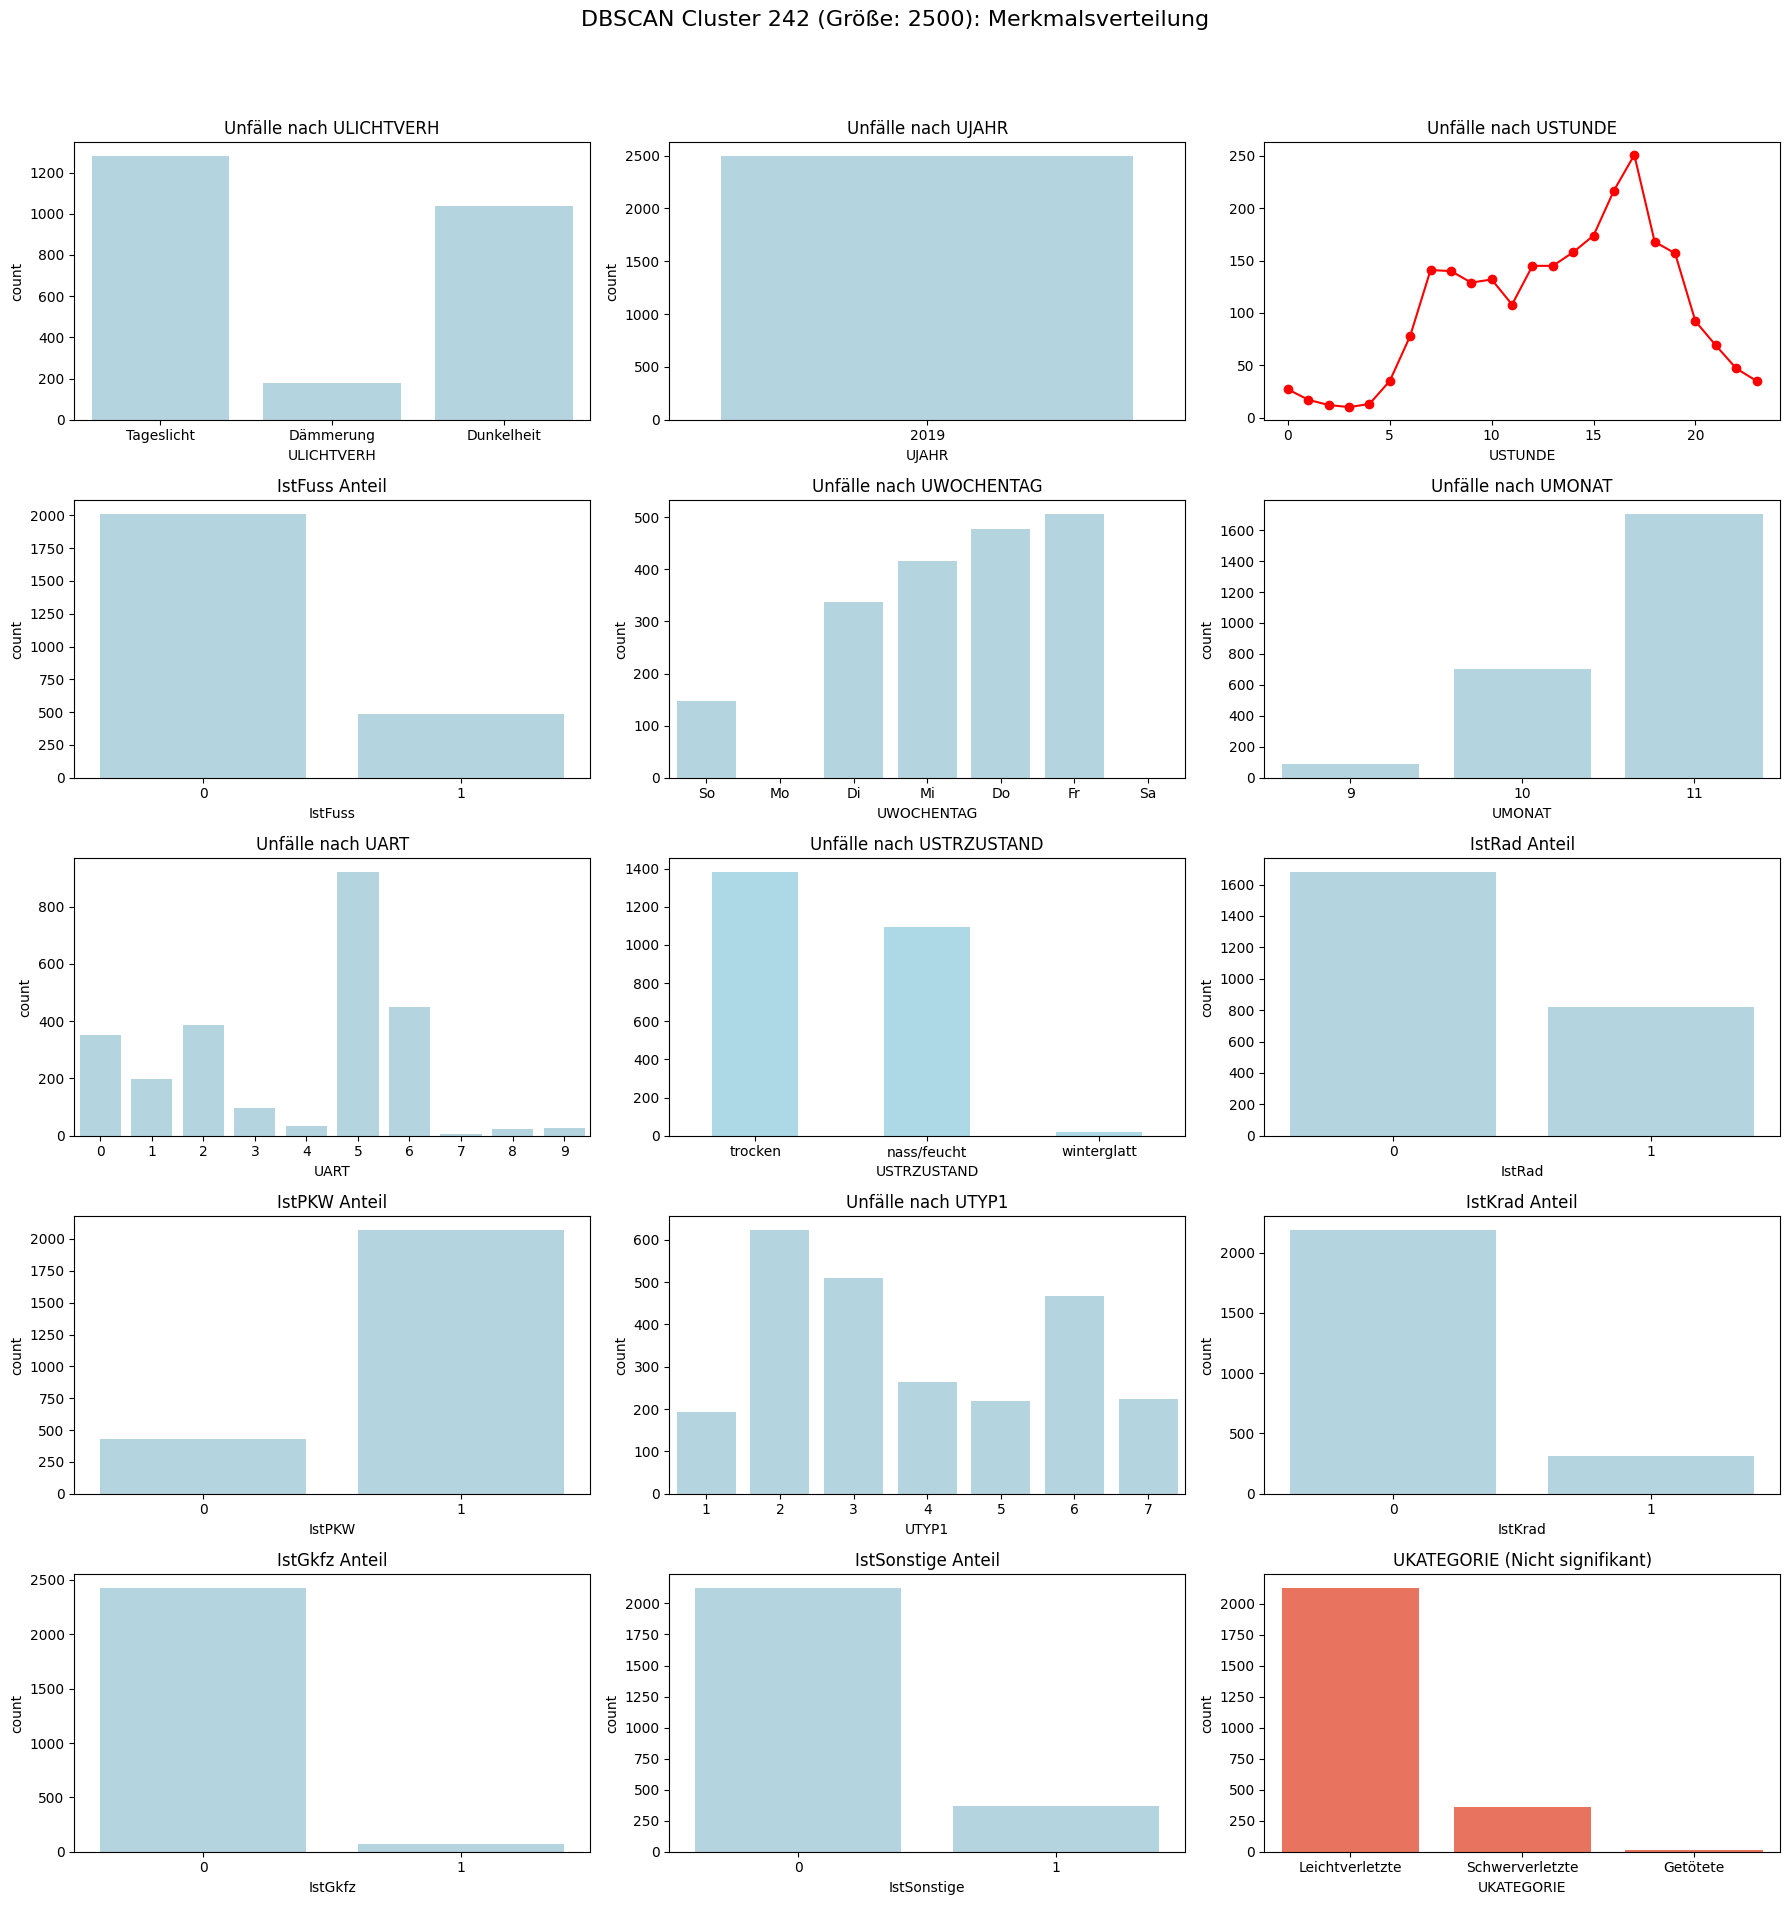

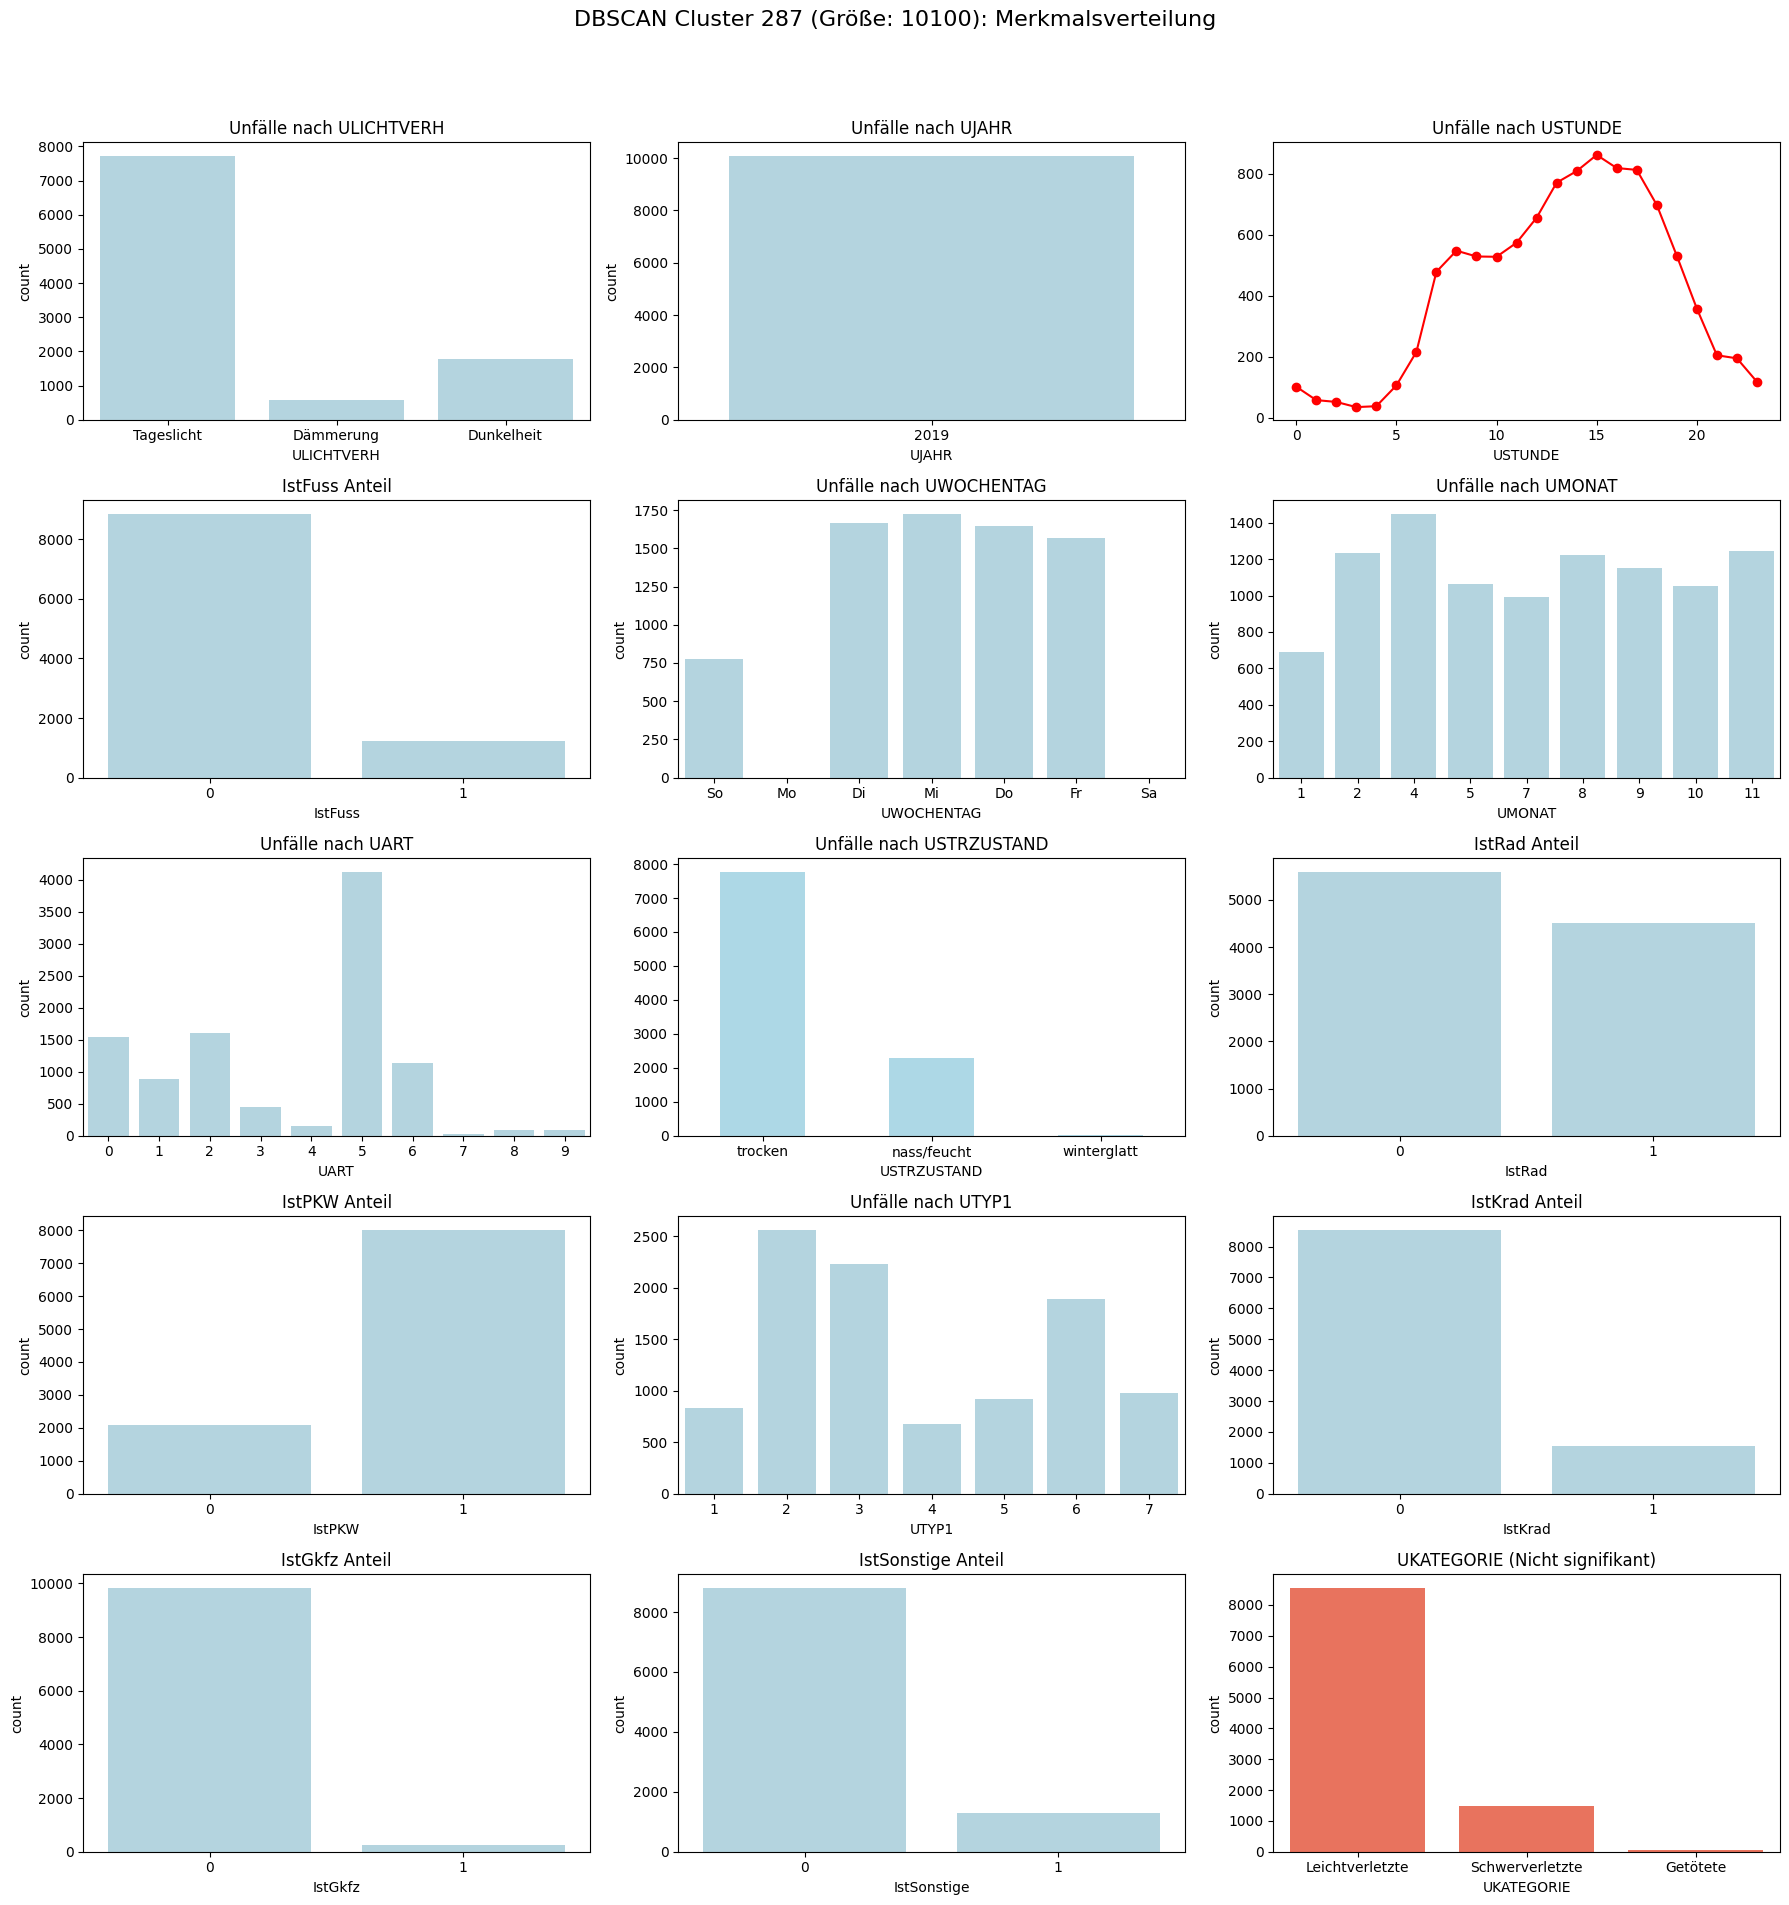

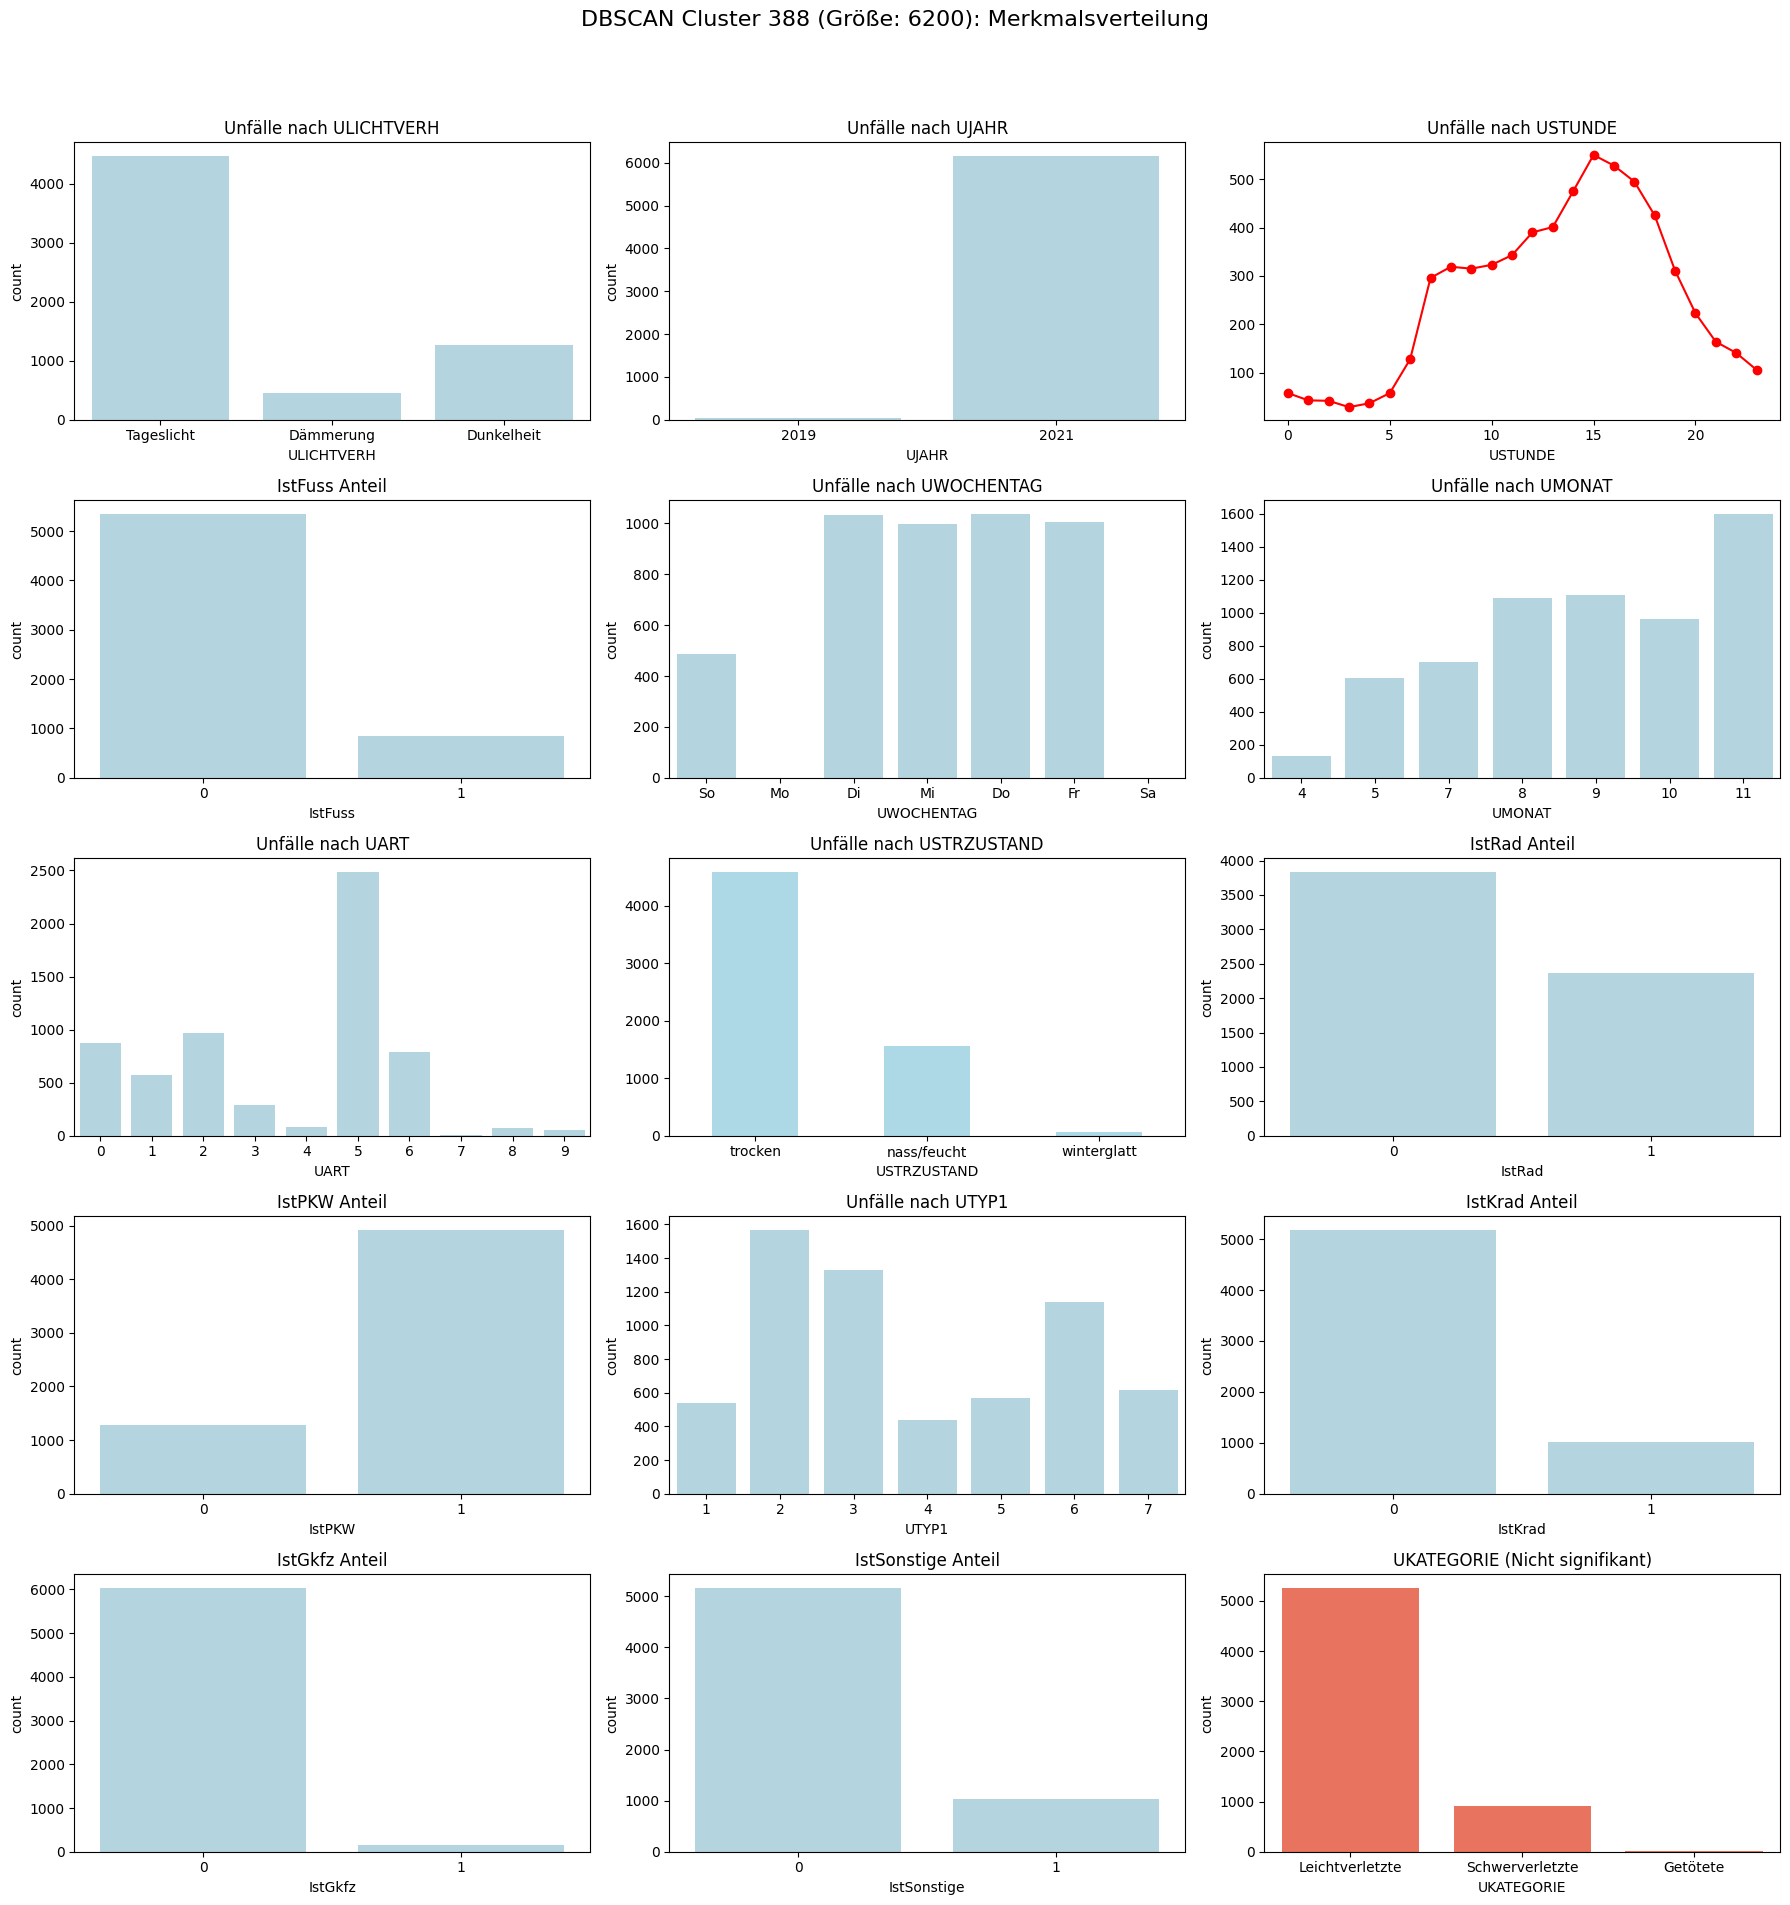

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Lade die Daten (hier nimmst du explizit die ersten 45.000 Zeilen)
df_encoded = pd.read_csv("dbscan_encoded_data.csv").iloc[:45000]

# Lade die DBSCAN-Labels
dbscan = joblib.load('dbscan_model.pkl')  # Falls das Modell geladen werden muss
cluster_labels = np.load("dbscan_merged_clusters.npy")

# Lade den Standard-Scaler und One-Hot-Encoder
minmax_scaler = joblib.load('dbscan_minmax_scaler.pkl')
onehot_encoder = joblib.load('dbscan_onehot_encoder.pkl')

# -----------------------------
# Variablen definieren
# -----------------------------
numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']
coordinate_vars = ['XGCSWGS84', 'YGCSWGS84']
ordinal_vars = ['UKATEGORIE']
nominal_vars = ['UART', 'UTYP1', 'ULICHTVERH', 'USTRZUSTAND']
binary_vars = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']

# Kombinierte Liste für kategoriale Variablen (nominal + ordinal)
categorical_vars = nominal_vars + ordinal_vars

# -----------------------------
# Daten zurücktransformieren
# -----------------------------
# Skalierte numerische Daten in Originalskala zurücktransformieren
all_numerical_vars = numerical_vars + ordinal_vars  # Alle numerischen + ordinale
df_encoded[all_numerical_vars] = minmax_scaler.inverse_transform(df_encoded[all_numerical_vars])

# One-Hot-Encoding rückgängig machen (für nominale Variablen)
onehot_columns = onehot_encoder.get_feature_names_out(nominal_vars)
df_nominal = pd.DataFrame(onehot_encoder.inverse_transform(df_encoded[onehot_columns]), columns=nominal_vars)

# Mapping für Lichtverhältnisse
licht_map = {0: "Tageslicht", 1: "Dämmerung", 2: "Dunkelheit"}
df_nominal['ULICHTVERH'] = df_nominal['ULICHTVERH'].map(licht_map)

# Ursprüngliche One-Hot-Spalten entfernen und durch die dekodierten Spalten ersetzen
df_encoded = df_encoded.drop(columns=onehot_columns)
df_encoded = pd.concat([df_encoded, df_nominal], axis=1)

# Füge die Cluster-Labels als neue Spalte in den DataFrame ein
df_encoded['Merged_Cluster'] = cluster_labels

# -----------------------------
# Clustergrößen berechnen
# -----------------------------
cluster_counts = df_encoded['Merged_Cluster'].value_counts().sort_index()
print("Clustergrößen:")
print(cluster_counts)

# -----------------------------
# Dynamische Subplots für jedes Cluster erstellen
# -----------------------------
# Lade die Kruskal-Wallis-Ergebnisse aus der ersten Datei (beispielsweise als CSV)
kruskal_df = pd.read_csv("Kruskal-Wallis_results_dbscan.csv")

# Filter für signifikante Features (p-value < 0.05)
significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]

# Sortiere nach H-statistik absteigend
significant_features_sorted = significant_features.sort_values(by='H-statistic', ascending=False)


# Mapping für Wochentage, nur einmal durchführen
wochentag_map = {
    1: "So", 2: "Mo", 3: "Di",
    4: "Mi", 5: "Do", 6: "Fr", 7: "Sa"
}

# Mapping für Unfallkategorie
ukategorie_map = {
    1: "Getötete",
    2: "Schwerverletzte",
    3: "Leichtverletzte"
}

# Mapping für Lichtverhältnisse
licht_map = {0: "Tageslicht", 1: "Dämmerung", 2: "Dunkelheit"}

# Sicherstellen, dass ULICHTV eine kategorische Variable mit einer festen Reihenfolge ist
df_encoded['ULICHTVERH'] = pd.Categorical(df_encoded['ULICHTVERH'], categories=["Tageslicht", "Dämmerung", "Dunkelheit"], ordered=True)

# Stelle sicher, dass die Reihenfolge von Sonntag bis Samstag geht
df_encoded['UWOCHENTAG'] = pd.Categorical(df_encoded['UWOCHENTAG'], 
                                           categories=[1, 2, 3, 4, 5, 6, 7], 
                                           ordered=True)

# Mapping für Wochentage
df_encoded['UWOCHENTAG'] = df_encoded['UWOCHENTAG'].map(wochentag_map)

# Mapping für Unfallkategorie
df_encoded['UKATEGORIE'] = df_encoded['UKATEGORIE'].map(ukategorie_map)

# Festgelegte Reihenfolge der Variablen
desired_feature_order = [
    'ULICHTVERH', 'UJAHR', 'USTUNDE', 'IstFuss', 'UWOCHENTAG', 'UMONAT', 'UART', 
    'USTRZUSTAND', 'IstRad', 'IstPKW', 'UTYP1', 'IstKrad', 'UKATEGORIE', 'IstGkfz', 'IstSonstige'
]

# Signifikante Features nach H-Statistik sortiert
significant_features_list = significant_features_sorted['Feature'].tolist()

# Koordinaten ausschließen
exclude_coordinates = ['XGCSWGS84', 'YGCSWGS84']

# **Filterung der Features für Visualisierung**
# Filtere nur signifikante Features basierend auf der gewünschten Reihenfolge und schließe Koordinaten aus
filtered_features = [feature for feature in desired_feature_order if feature in significant_features_list and feature not in exclude_coordinates]

# Bestimme die nicht signifikanten Features basierend auf der gewünschten Reihenfolge und den gefilterten Features
non_significant_features = [feature for feature in desired_feature_order if feature not in filtered_features and feature not in exclude_coordinates]

# Stelle sicher, dass UMONAT als numerische Variable behandelt wird (1 bis 12)
df_encoded['UMONAT'] = df_encoded['UMONAT'].astype(int)
df_encoded['UJAHR'] = df_encoded['UJAHR'].astype(int)

for feature in non_significant_features:
    filtered_features.append(feature)
    
# Dynamische Subplots für jedes Cluster erstellen
for cluster in df_encoded['Merged_Cluster'].unique():
    df_cluster = df_encoded[df_encoded['Merged_Cluster'] == cluster].copy()

    if df_cluster.empty:
        continue  # Falls keine Daten vorhanden, Cluster überspringen

    # Liste der zu plottenden Variablen (ULICHTVERH an erster Stelle)
    plots = []  # Leere Liste für Plots

    # Füge alle weiteren signifikanten Features hinzu, jedoch ohne ULICHTVERH
    for i, feature in enumerate(filtered_features):
        if feature in df_cluster.columns and not df_cluster[feature].isna().all():
            # Wenn das Feature nicht signifikant ist, markiere es entsprechend
            is_non_significant = feature in non_significant_features

            if is_non_significant:
                # Verwende eine spezielle Farbe für nicht signifikante Features
                plots.append((feature, '#FF6347', f'{feature} (Nicht signifikant)'))  # Tomatenrot für nicht signifikant
            else:
                # Normale Farbe für signifikante Features
                if feature in binary_vars:
                    plots.append((feature, '#ADD8E6', f'{feature} Anteil'))
                else:
                    plots.append((feature, '#ADD8E6', f'Unfälle nach {feature}'))

    # Dynamische Anzahl der Subplots bestimmen
    n_plots = len(plots)
    n_cols = 3  # Maximal 3 Spalten nebeneinander
    n_rows = int(np.ceil(n_plots / n_cols))  # Reihenanzahl berechnen

    # Erstelle Subplots mit ausreichender Anzahl an Achsen
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    
    # Flatten der Achsen für einfacheren Zugriff
    axes = axes.flatten()

    # Clustergröße im Titel anzeigen
    fig.suptitle(f'DBSCAN Cluster {cluster} (Größe: {cluster_counts[cluster]}): Merkmalsverteilung', fontsize=16)

    # Durch die gesammelten Plots iterieren und sie auf den Achsen platzieren
    for i, (feature, color, title) in enumerate(plots):
        ax = axes[i]

        if feature == 'USTUNDE':  # Liniendiagramm für Stunden, bleibt rot
            df_cluster['USTUNDE'].value_counts().sort_index().plot(
                kind='line', ax=ax, color='red', marker='o'
            )
        elif feature == 'USTRZUSTAND':  # Balkendiagramm mit festen Labels für USTRZUSTAND
            ustrzustand_counts = df_cluster['USTRZUSTAND'].value_counts().sort_index()
            ustrzustand_counts = ustrzustand_counts.reindex([0, 1, 2], fill_value=0)
            ustrzustand_counts.plot(kind='bar', ax=ax, color=color)
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(['trocken', 'nass/feucht', 'winterglatt'], rotation=0)
        elif feature == 'UWOCHENTAG':  # Wochentage korrekt darstellen
            sns.countplot(x=feature, data=df_cluster, ax=ax, hue=feature, palette=[color]*7, order=["So", "Mo", "Di", "Mi", "Do", "Fr", "Sa"], dodge=False, legend=False)
            ax.set_title('Unfälle nach Wochentag')
        elif feature == 'UKATEGORIE':  # Unfallkategorie korrekt darstellen
            sns.countplot(x=feature, data=df_cluster, ax=ax, hue=feature, palette=[color]*len(df_cluster['UKATEGORIE'].unique()), order=["Leichtverletzte", "Schwerverletzte", "Getötete"], legend=False)
            ax.set_title('Unfälle nach Unfallkategorie')
        else:  # Standard-Balkendiagramme mit dem helleren blauen Farbton
            sns.countplot(x=feature, data=df_cluster, ax=ax, color=color, legend=False)

        ax.set_title(title)

    # Leere Achsen ausblenden
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"output/plots/DBSCAN_Cluster_{cluster}_features.png", dpi=100, bbox_inches="tight")
    plt.show()
